<a href="https://colab.research.google.com/github/JHyunjun/torch_Generative-Adversarial-Network/blob/main/250322_Delete_DeltaV_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')
print("Available GPUs:", tf.config.list_physical_devices('GPU'))
# from tensorflow.python.client import device_lib
# print(device_lib.list_local_devices())

# tf.config.list_physical_devices('GPU')

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv1D, BatchNormalization, Dropout, Flatten, Dense, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from keras.models import load_model
from tensorflow.keras.optimizers.schedules import ExponentialDecay


Available GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 4060 Laptop GPU, compute capability 8.9
Final sequences shape: (4465, 60, 4)


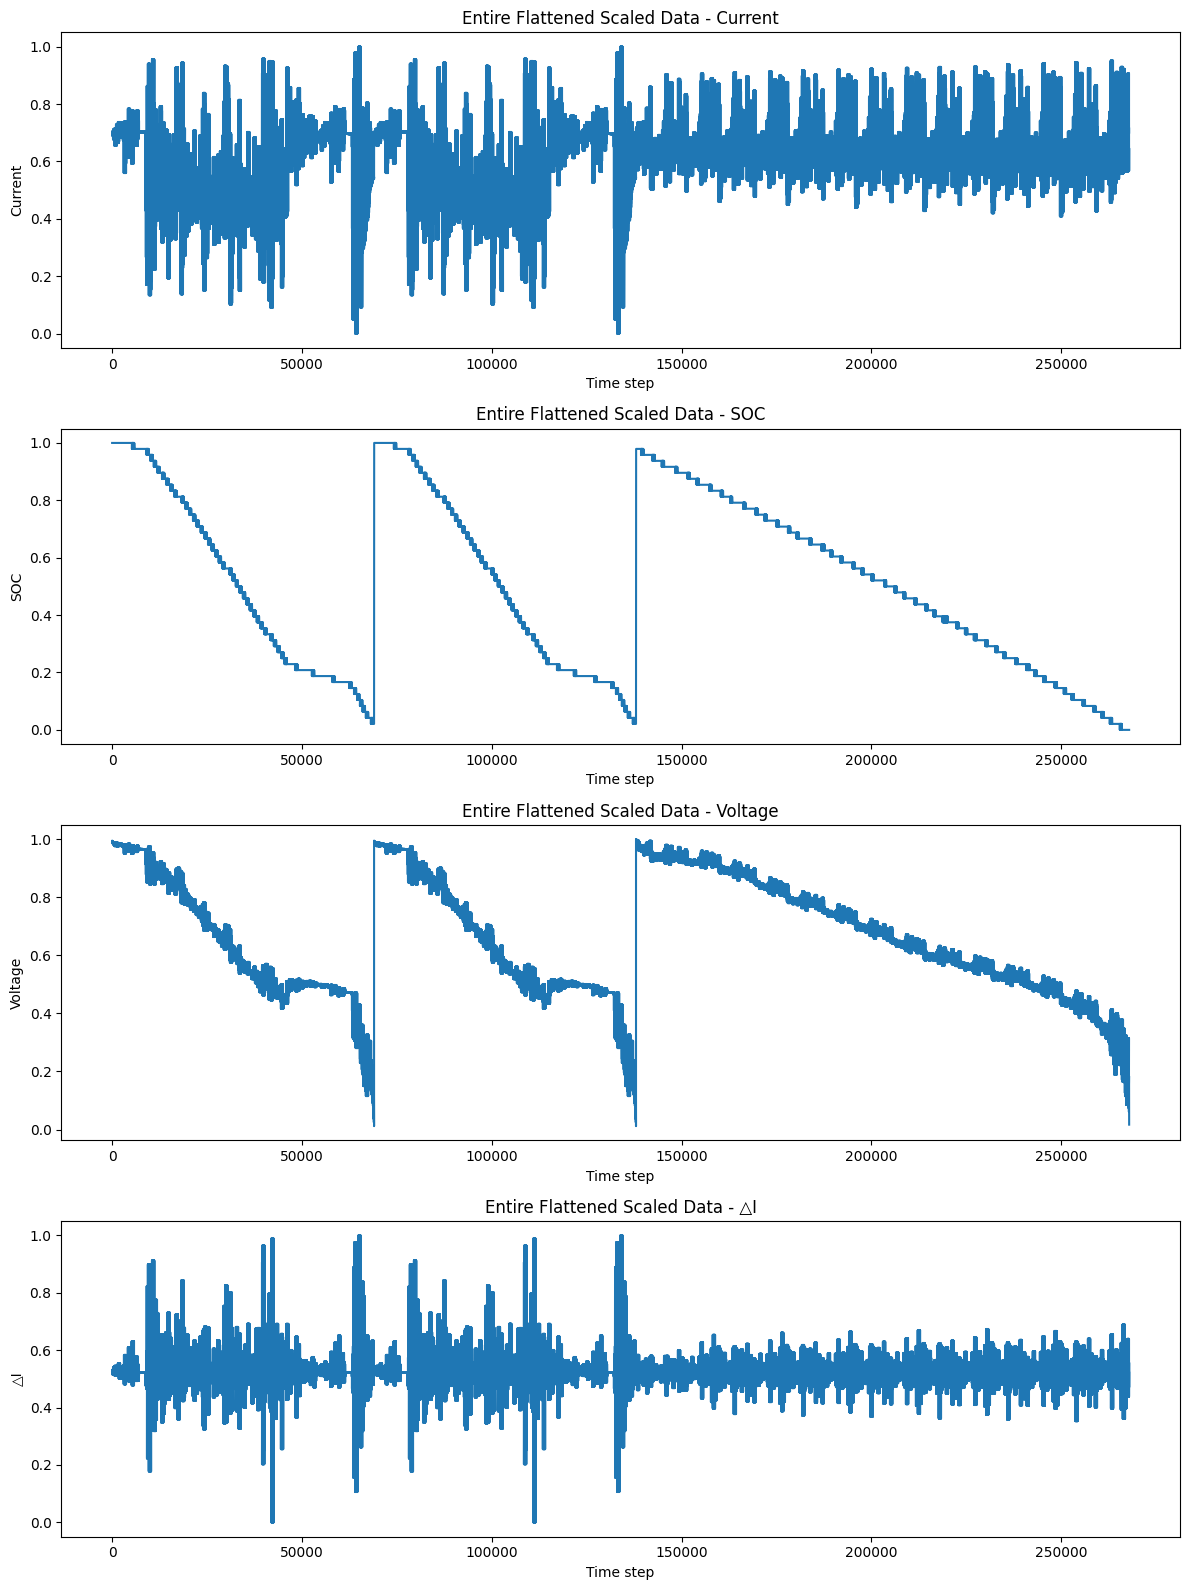

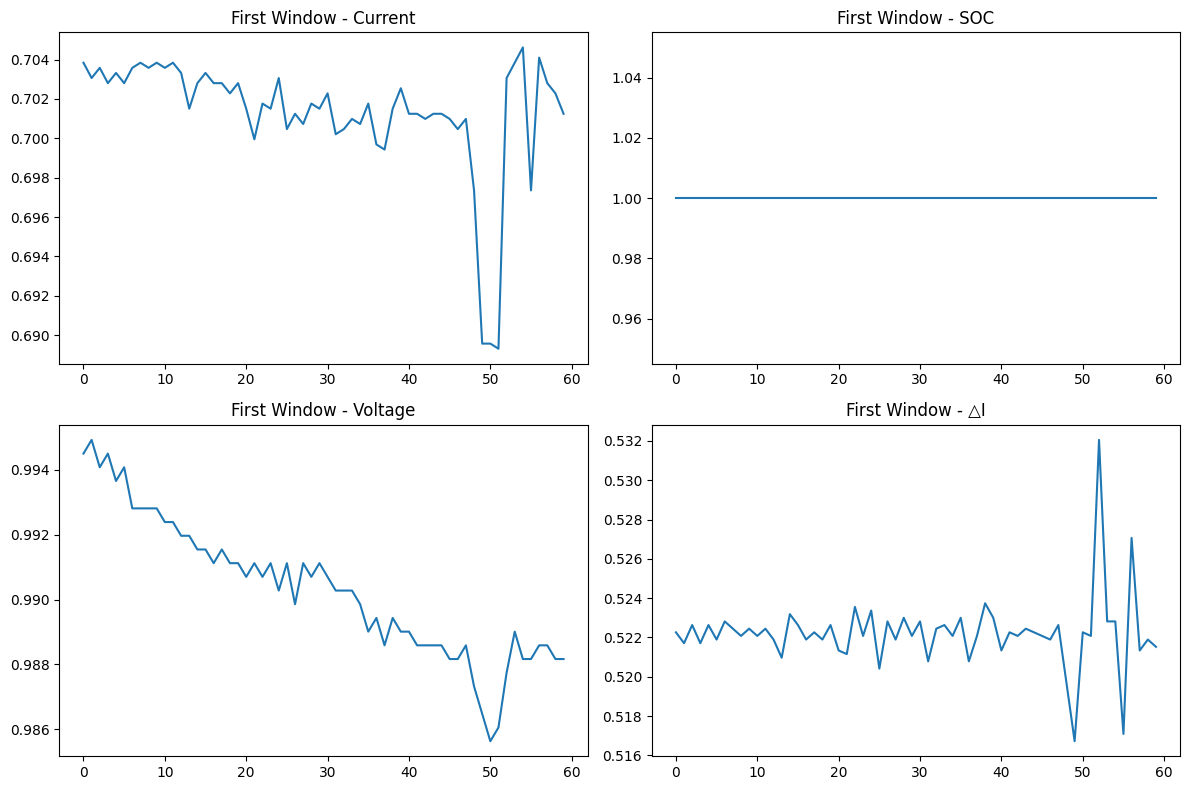

Unique train SOC values: [4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98]
Unique test SOC values: [2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96]


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

# Mixed precision 설정 (옵션)
tf.keras.mixed_precision.set_global_policy('mixed_float16')

# ----------------------------------------
# 1. 데이터 로드 및 전처리
# ----------------------------------------
def MinMaxScaler(data, data_min, data_max):
    return (data - data_min) / (data_max - data_min + 1e-7)

# 파일 경로 (환경에 맞게 수정)
train_path = r"C:\Users\user\Desktop\SNU\논문코드\JSAEGAN\train_v.txt"
test_path  = r"C:\Users\user\Desktop\SNU\논문코드\JSAEGAN\test_v.txt"

# 데이터 로드
train_data = pd.read_csv(train_path, delimiter=",")
test_data  = pd.read_csv(test_path, delimiter=",")

# 필요한 열 선택: 0번(Current), 2번(SOC), 4번(Voltage)
cols = ['Current', 'SOC', 'Voltage']
train_data = train_data.iloc[:, [0, 2, 4]]
test_data  = test_data.iloc[:, [0, 2, 4]]
train_data.columns = cols
test_data.columns  = cols

# SOC 컬럼을 2% 단위로 버림 처리하는 함수 정의
def quantize_soc(soc):
    soc_int = int(soc)           # 소수점 버림
    if soc_int == 100:           # 100인 경우 특별 처리: 100 → 98
        return 98
    if soc_int % 2 != 0:         # 홀수이면 1 감소시켜 짝수로 만듦
        return soc_int - 1
    return soc_int

# train과 test 데이터에 대해 SOC 변환 적용
train_data['SOC'] = train_data['SOC'].apply(quantize_soc)
test_data['SOC'] = test_data['SOC'].apply(quantize_soc)

# △I 열만 추가 (△V 열은 추가하지 않음)
for df in [train_data, test_data]:
    df['△I'] = df['Current'].diff().fillna(0)

# 최종 컬럼 순서: ['Current', 'SOC', 'Voltage', '△I']
final_cols = ['Current', 'SOC', 'Voltage', '△I']
train_data = train_data[final_cols]
test_data  = test_data[final_cols]

# ----------------------------------------
# 2. 데이터 스케일링 (전체 기준)
# ----------------------------------------
combined_data = pd.concat([train_data, test_data], ignore_index=True)
data_min = combined_data.min().values
data_max = combined_data.max().values

train_scaled = MinMaxScaler(train_data.values, data_min, data_max)
test_scaled  = MinMaxScaler(test_data.values, data_min, data_max)

# ----------------------------------------
# 3. 개별적으로 슬라이딩 윈도우 생성
# ----------------------------------------
window_size = 60
overlap_factor = 0.9

def create_sequences(data, window_size, overlap):
    stride = int(window_size * (1 - overlap))
    sequences = []
    for i in range(0, len(data) - window_size + 1, stride):
        sequences.append(data[i:i+window_size])
    return np.array(sequences)

train_sequences = create_sequences(train_scaled, window_size, overlap_factor)
test_sequences  = create_sequences(test_scaled, window_size, overlap_factor)

# ----------------------------------------
# 4. train_sequences를 3번 반복한 뒤 test_sequences와 합쳐 최종 데이터 구성
# ----------------------------------------
final_sequences = np.concatenate([train_sequences, train_sequences, test_sequences], axis=0)
print("Final sequences shape:", final_sequences.shape)
all_sequences = final_sequences

# 전체 시퀀스를 평탄화(flatten)하여 전체 시간축에서 시각화
flat_sequences = final_sequences.reshape(-1, final_sequences.shape[-1])

# ----------------------------------------
# 5. 전체 시간축에 대한 시각화
# ----------------------------------------
feature_names = ['Current', 'SOC', 'Voltage', '△I']
plt.figure(figsize=(12, 16))
for i, col in enumerate(feature_names):
    plt.subplot(len(feature_names), 1, i+1)
    plt.plot(flat_sequences[:, i])
    plt.title(f'Entire Flattened Scaled Data - {col}')
    plt.ylabel(col)
    plt.xlabel('Time step')
plt.tight_layout()
plt.show()

# ----------------------------------------
# 6. 첫 번째 슬라이딩 윈도우 시각화 (확인용)
# ----------------------------------------
plt.figure(figsize=(12, 8))
for i, col in enumerate(feature_names):
    plt.subplot(2, 2, i+1)
    plt.plot(final_sequences[0, :, i])
    plt.title(f"First Window - {col}")
plt.tight_layout()
plt.show()

# 전처리 후 SOC 고유값 확인하기
unique_train_soc = sorted(train_data['SOC'].unique())
unique_test_soc = sorted(test_data['SOC'].unique())

print("Unique train SOC values:", unique_train_soc)
print("Unique test SOC values:", unique_test_soc)


Teacher X shape: (4465, 60, 3)
Teacher Y shape: (4465, 60, 1)
1/1 [==============================] - 4s 4s/step


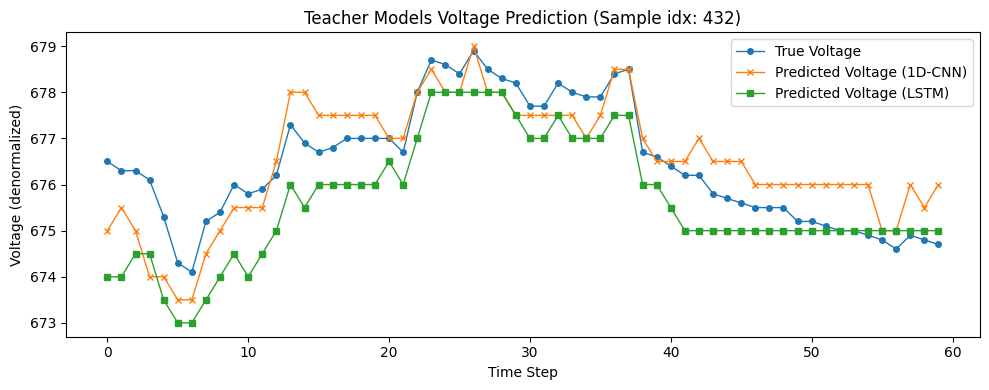

1/1 [==============================] - 0s 18ms/step


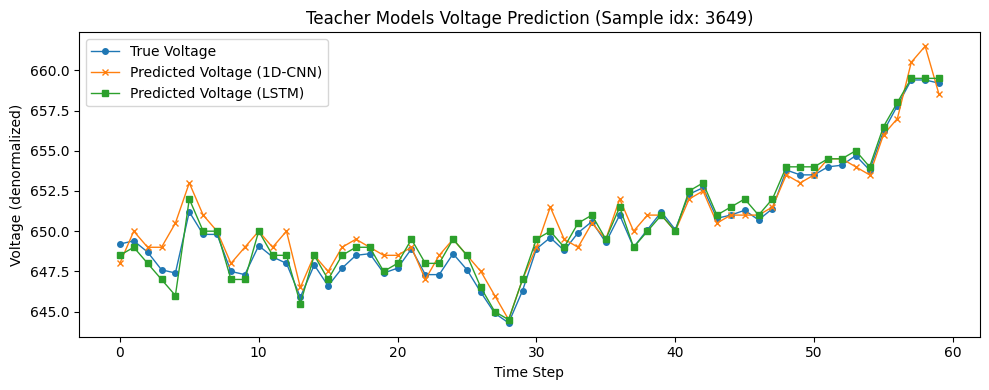

1/1 [==============================] - 0s 18ms/step


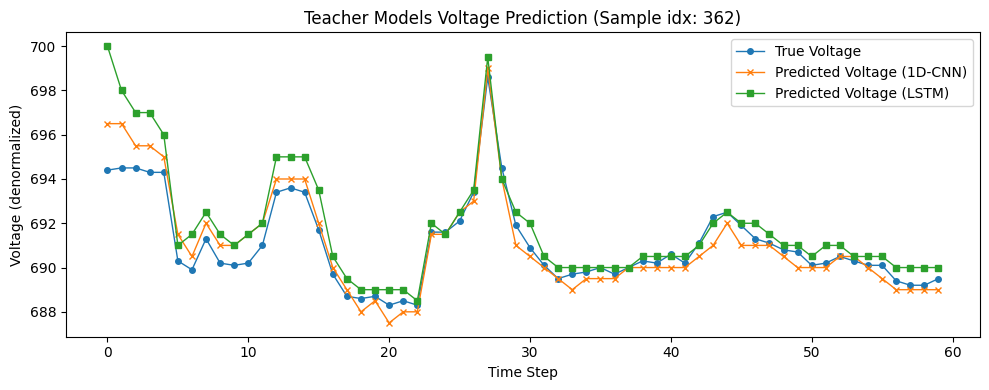

140/140 [==============================] - 1s 7ms/step


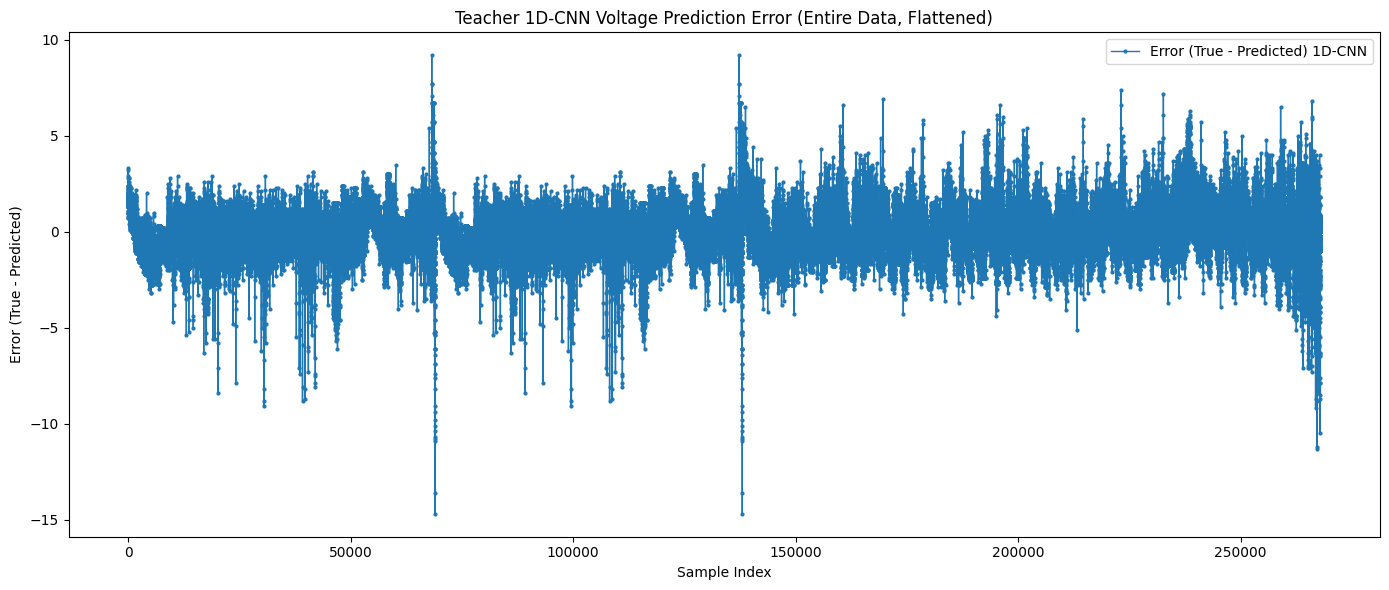

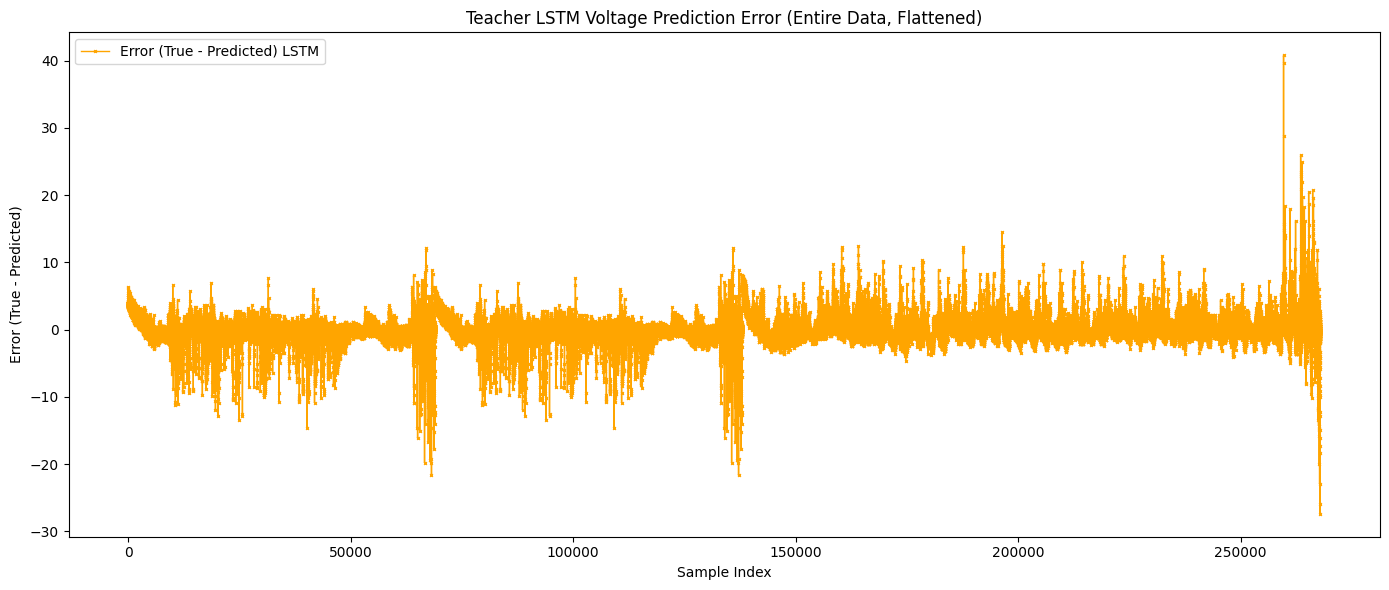

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv1D, LSTM, TimeDistributed, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler

# Mixed precision 설정 (옵션)
tf.keras.mixed_precision.set_global_policy('mixed_float16')

############################################
# 3. Teacher 모델 학습 데이터 구성
############################################

# Teacher 모델 입력: 이제 [Current, SOC, △I]만 사용 (ΔV 제거)
teacher_X = all_sequences[..., [0, 1, 3]]  # shape: (N, window_size, 3)
teacher_Y = all_sequences[..., 2:3]         # shape: (N, window_size, 1)

print("Teacher X shape:", teacher_X.shape)
print("Teacher Y shape:", teacher_Y.shape)

############################################
# 4. Teacher 모델 정의 & 학습 (Learning Rate Decay 포함)
############################################

# Learning Rate Scheduler: 매 100 epoch마다 lr를 0.95배로 감소
def lr_schedule(epoch, lr):
    if epoch > 0 and epoch % 100 == 0:
        return lr * 0.95
    return lr

lr_callback = LearningRateScheduler(lr_schedule, verbose=1)

# # 4.1 1D-CNN Teacher 모델
# def build_teacher_1d_cnn(input_shape):
#     inp = Input(shape=input_shape)  # 이제 input_shape: (window_size, 3)
#     x = Conv1D(filters=64, kernel_size=5, padding='same', activation='relu')(inp)
#     x = Conv1D(filters=64, kernel_size=5, padding='same', activation='relu')(x)
#     x = Conv1D(filters=32, kernel_size=3, padding='same', activation='relu')(x)
#     x = Conv1D(filters=32, kernel_size=3, padding='same', activation='relu')(x)
#     out = Conv1D(filters=1, kernel_size=1, padding='same', activation='sigmoid')(x)
#     model = Model(inp, out, name="Teacher_1D_CNN")
#     return model

# # 입력 shape을 (window_size, 3)으로 설정
# teacher_1d = build_teacher_1d_cnn((window_size, 3))
# teacher_1d.summary()
# teacher_1d.compile(optimizer=Adam(learning_rate=5e-4), loss='mse')

# history_1d = teacher_1d.fit(teacher_X, teacher_Y,
#                              epochs=2000,
#                              batch_size=64,
#                              callbacks=[lr_callback],
#                              verbose=1)

# teacher_1d.save("refined_1d_cnn_deletedV_250321.h5")
# print("1D-CNN Teacher model saved as refined_1d_cnn_deletedV_250321.h5")

teacher_1d = tf.keras.models.load_model("refined_1d_cnn_deletedV_250321.h5")

# # 4.2 LSTM Teacher 모델
# def build_teacher_lstm(input_shape):
#     inp = Input(shape=input_shape, dtype='float32')  # input_shape: (window_size, 3)
#     x = LSTM(128, return_sequences=True)(inp)
#     x = LSTM(128, return_sequences=True)(x)
#     x = LSTM(64, return_sequences=True)(x)
#     x = LSTM(64, return_sequences=True)(x)
#     out = TimeDistributed(Dense(1, activation='sigmoid'))(x)
#     model = Model(inp, out, name="Teacher_LSTM")
#     return model

# teacher_lstm = build_teacher_lstm((window_size, 3))
# teacher_lstm.summary()
# teacher_lstm.compile(optimizer=Adam(learning_rate=5e-4), loss='mse')

# history_lstm = teacher_lstm.fit(teacher_X, teacher_Y,
#                                 epochs=1000,
#                                 batch_size=64,
#                                 callbacks=[lr_callback],
#                                 verbose=1)

# teacher_lstm.save("refined_lstm_deletedV_250321.h5")
# print("LSTM Teacher model saved as refined_lstm_deletedV_250321.h5")

teacher_lstm = tf.keras.models.load_model("refined_lstm_deletedV_250321.h5")


# denorm_vector 함수: vec는 1D 배열, feature_index는 전압에 해당하는 인덱스 (여기서는 2)
def denorm_vector(vec, feature_index, data_min, data_max):
    return vec * (data_max[feature_index] - data_min[feature_index] + 1e-7) + data_min[feature_index]

# teacher_X와 teacher_Y의 첫 번째 차원은 샘플 개수
num_samples = teacher_X.shape[0]
# 3개의 랜덤 샘플 인덱스 선택
random_indices = np.random.choice(num_samples, size=3, replace=False)

for idx in random_indices:
    # (1) 해당 샘플의 Teacher 입력과 정답 추출
    sample_input = teacher_X[idx:idx+1]  # shape: (1, window_size, 3)
    sample_true  = teacher_Y[idx:idx+1]   # shape: (1, window_size, 1)

    # (2) 각 Teacher 모델 예측
    pred_cnn = teacher_1d.predict(sample_input)    # (1, window_size, 1)
    pred_lstm = teacher_lstm.predict(sample_input)   # (1, window_size, 1)

    # (3) Flatten: (window_size,)
    pred_cnn_flat = pred_cnn.reshape(-1)
    pred_lstm_flat = pred_lstm.reshape(-1)
    true_flat = sample_true.reshape(-1)

    # (4) Denormalize: 전압은 feature index 2 사용 (data_min, data_max 배열 기준)
    true_denorm = denorm_vector(true_flat, 2, data_min, data_max)
    pred_cnn_denorm = denorm_vector(pred_cnn_flat, 2, data_min, data_max)
    pred_lstm_denorm = denorm_vector(pred_lstm_flat, 2, data_min, data_max)

    # (5) 플롯: 한 Figure에 실제 전압과 두 Teacher 모델 예측 전압 비교
    plt.figure(figsize=(10,4))
    plt.plot(true_denorm, label="True Voltage", marker='o', markersize=4, linewidth=1)
    plt.plot(pred_cnn_denorm, label="Predicted Voltage (1D-CNN)", marker='x', markersize=4, linewidth=1)
    plt.plot(pred_lstm_denorm, label="Predicted Voltage (LSTM)", marker='s', markersize=4, linewidth=1)
    plt.title(f"Teacher Models Voltage Prediction (Sample idx: {idx})")
    plt.xlabel("Time Step")
    plt.ylabel("Voltage (denormalized)")
    plt.legend()
    plt.tight_layout()
    plt.show()

# Teacher 모델 예측 수행 (전체 데이터)
pred_cnn = teacher_1d.predict(teacher_X)      # (N, window_size, 1)
pred_lstm = teacher_lstm.predict(teacher_X)     # (N, window_size, 1)
true_vals = teacher_Y                           # (N, window_size, 1)

# 전체 데이터를 1D 벡터로 flatten (N * window_size,)
pred_cnn_flat = pred_cnn.reshape(-1)
pred_lstm_flat = pred_lstm.reshape(-1)
true_flat = true_vals.reshape(-1)

# Denormalize: 전압은 원래 데이터에서 feature index 2 (즉, combined_data의 두번째 인덱스)에 해당
true_denorm = denorm_vector(true_flat, 2, data_min, data_max)
pred_cnn_denorm = denorm_vector(pred_cnn_flat, 2, data_min, data_max)
pred_lstm_denorm = denorm_vector(pred_lstm_flat, 2, data_min, data_max)

# 오차 계산: (실제 전압 - 예측 전압)
error_cnn = true_denorm - pred_cnn_denorm
error_lstm = true_denorm - pred_lstm_denorm

# 1D-CNN Teacher 모델 오차 플롯
plt.figure(figsize=(14,6))
plt.plot(error_cnn, label="Error (True - Predicted) 1D-CNN", marker='o', markersize=2, linewidth=1)
plt.title("Teacher 1D-CNN Voltage Prediction Error (Entire Data, Flattened)")
plt.xlabel("Sample Index")
plt.ylabel("Error (True - Predicted)")
plt.legend()
plt.tight_layout()
plt.show()

# LSTM Teacher 모델 오차 플롯
plt.figure(figsize=(14,6))
plt.plot(error_lstm, label="Error (True - Predicted) LSTM", marker='x', markersize=2, linewidth=1, color='orange')
plt.title("Teacher LSTM Voltage Prediction Error (Entire Data, Flattened)")
plt.xlabel("Sample Index")
plt.ylabel("Error (True - Predicted)")
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense, Reshape, LeakyReLU, ConvLSTM2D, TimeDistributed, Conv2D, Flatten, Input, Concatenate, Conv1D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam

# Hyper Parameters
# 원본 all_sequences는 4채널: [전류, SOC, 전압, ΔI]
feature_dim = 4
latent_dim = 10        # 노이즈 차원
batch_size = 128
epochs = 3000
n_critic = 3
lambda_gp = 10.0
learning_rate = 5e-4
window_size = 60

tf.keras.mixed_precision.set_global_policy('mixed_float16')

# Global batch counter for mode seeking loss
global_batch_counter = tf.Variable(0, trainable=False, dtype=tf.int32)

# --- Gradient Penalty 계산 함수 (WGAN-GP) ---
@tf.function
def gradient_penalty(discriminator, real_samples, fake_samples):
    fake_samples = tf.cast(fake_samples, real_samples.dtype)
    b = tf.shape(real_samples)[0]
    alpha = tf.random.uniform([b, 1, 1], 0.0, 1.0, dtype=real_samples.dtype)
    interpolated = alpha * real_samples + (1 - alpha) * fake_samples
    with tf.GradientTape() as gp_tape:
        gp_tape.watch(interpolated)
        pred = discriminator(interpolated, training=True)
    grads = gp_tape.gradient(pred, [interpolated])[0]
    grad_norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2]))
    gp = tf.reduce_mean((grad_norm - 1.0) ** 2)
    return gp

# Teacher 모델들은 외부에서 정의된 것으로 가정 (teacher_1d, teacher_lstm)
teacher_model = teacher_1d      # 예: 1-D CNN Teacher
teacher_model_2 = teacher_lstm  # 예: LSTM Teacher
teacher_model.trainable = False
teacher_model_2.trainable = False

# --- Generator ---
def get_condition(real_series):
    # real_series: (batch, window_size, feature_dim) with ordering [전류, SOC, 전압, ΔI]
    # 윈도우의 마지막 SOC 값을 조건으로 복제
    soc = real_series[:, -1, 1]        # (batch,)
    soc = tf.expand_dims(soc, axis=1)    # (batch, 1)
    soc = tf.tile(soc, [1, window_size]) # (batch, window_size)
    soc = tf.expand_dims(soc, axis=-1)   # (batch, window_size, 1)
    return soc

def build_generator_cond(latent_dim, window_size):
    # 노이즈 입력: (window_size, latent_dim)
    noise_inp = Input(shape=(window_size, latent_dim))
    # 조건 입력: (window_size, 1)
    cond_inp = Input(shape=(window_size, 1))

    # Concatenate noise와 조건
    x = Concatenate(axis=-1)([noise_inp, cond_inp])  # (window_size, latent_dim+1)

    # 여러 개의 1D Conv 블록
    x = Conv1D(filters=64, kernel_size=3, padding='same')(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Conv1D(filters=64, kernel_size=3, padding='same')(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Conv1D(filters=64, kernel_size=3, padding='same')(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Conv1D(filters=64, kernel_size=3, padding='same')(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Conv1D(filters=64, kernel_size=3, padding='same')(x)
    x = LeakyReLU(alpha=0.2)(x)
    # 최종 출력: 각 타임스텝마다 3개 값: [전류, ΔI, 전압]
    out = Dense(3, activation='sigmoid')(x)

    model = Model([noise_inp, cond_inp], out, name="Generator_1D")
    return model

def combine_output(dynamic, cond):
    return dynamic

generator_cond = build_generator_cond(latent_dim, window_size)

# --- Discriminator ---
def build_discriminator(window_size):
    inp = Input(shape=(window_size, 3))  # [전류, ΔI, 전압]
    x = Conv1D(filters=32, kernel_size=3, padding='same')(inp)
    x = LeakyReLU(alpha=0.2)(x)
    x = Conv1D(filters=16, kernel_size=3, padding='same')(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Conv1D(filters=16, kernel_size=3, padding='same')(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Flatten()(x)
    out = Dense(1)(x)
    model = Model(inp, out, name="Discriminator_1D")
    return model

discriminator = build_discriminator(window_size)

# --- Optimizers and Dataset ---
generator_optimizer = Adam(learning_rate=learning_rate, beta_1=0.5, beta_2=0.9)
discriminator_optimizer = Adam(learning_rate=learning_rate, beta_1=0.5, beta_2=0.9)
dataset = tf.data.Dataset.from_tensor_slices(all_sequences.astype('float32')) \
            .shuffle(buffer_size=1024).batch(batch_size).prefetch(tf.data.AUTOTUNE)

# --- Correlation 기반 Mode Seeking Loss 함수 ---
def correlation_coeff_batch(x, y, eps):
    # x, y: shape (batch_size, time_steps)
    x = tf.cast(x, eps.dtype)
    y = tf.cast(y, eps.dtype)
    x_mean = tf.reduce_mean(x, axis=1, keepdims=True)
    y_mean = tf.reduce_mean(y, axis=1, keepdims=True)
    cov = tf.reduce_mean((x - x_mean) * (y - y_mean), axis=1)
    std_x = tf.math.reduce_std(x, axis=1)
    std_y = tf.math.reduce_std(y, axis=1)
    corr = cov / (std_x * std_y + eps)
    return corr

def mode_seeking_loss_corr(generator, cond, batch_size, latent_dim, window_size):
    # cond: (batch_size, window_size, 1)
    eps = tf.cast(1e-7, cond.dtype)
    noise1 = tf.random.normal([batch_size, window_size, latent_dim], dtype=cond.dtype)
    noise2 = tf.random.normal([batch_size, window_size, latent_dim], dtype=cond.dtype)

    out1 = combine_output(generator([noise1, cond], training=True), cond)  # (batch_size, window_size, 4)
    out2 = combine_output(generator([noise2, cond], training=True), cond)  # (batch_size, window_size, 4)

    # 전류 채널 (인덱스 0) 추출
    out1_current = out1[..., 0]  # (batch_size, window_size)
    out2_current = out2[..., 0]

    corr = correlation_coeff_batch(out1_current, out2_current, eps)  # (batch_size,)
    loss = tf.reduce_mean(tf.abs(corr))
    return loss

# --- 새로운 Condition-based Mode Seeking Loss 함수 ---
def condition_mode_seeking_loss(generator, real_series, latent_dim, window_size):
    """
    real_series: (batch_size, window_size, feature_dim) with feature_dim=4 ([Current, SOC, Voltage, ΔI])
    동일 노이즈를 사용하여, 배치 내에서 서로 다른 두 샘플 쌍에 대해 Generator의 출력(전류 채널)의
    상관계수의 절댓값 평균을 계산합니다.
    배치 내에서 50% 쌍(예: batch_size가 128이면 64 쌍)을 무작위로 선택하여 계산합니다.
    """
    eps = tf.cast(1e-7, real_series.dtype)
    b = tf.shape(real_series)[0]
    num_pairs = b // 2  # 예: 128 -> 64쌍
    indices = tf.random.shuffle(tf.range(b))
    selected_indices = indices[:2 * num_pairs]
    pair_indices = tf.reshape(selected_indices, (num_pairs, 2))

    def compute_pair_corr(pair):
        i = pair[0]
        j = pair[1]
        cond_i = get_condition(tf.expand_dims(real_series[i], axis=0))  # (1, window_size, 1)
        cond_j = get_condition(tf.expand_dims(real_series[j], axis=0))
        noise = tf.random.normal([1, window_size, latent_dim], dtype=real_series.dtype)
        out_i = combine_output(generator([noise, cond_i], training=True), cond_i)  # (1, window_size, 4)
        out_j = combine_output(generator([noise, cond_j], training=True), cond_j)
        current_i = out_i[..., 0]  # (1, window_size)
        current_j = out_j[..., 0]
        corr = correlation_coeff_batch(current_i, current_j, eps)  # (1,)
        # squeeze하여 스칼라로 만듭니다.
        return tf.squeeze(tf.abs(corr), axis=0)

    pair_corrs = tf.map_fn(compute_pair_corr, pair_indices,
                            fn_output_signature=tf.TensorSpec(shape=(), dtype=real_series.dtype))
    loss = tf.reduce_mean(pair_corrs)
    return loss



# -----------------------------
# Training Step
# -----------------------------
@tf.function
def train_step(real_series):
    # real_series: (batch, window_size, 4) with ordering [전류, SOC, 전압, ΔI]
    cond = get_condition(real_series)  # (batch, window_size, 1)

    noise = tf.random.normal([tf.shape(real_series)[0], window_size, latent_dim], dtype=real_series.dtype)
    latent_fake = generator_cond([noise, cond], training=True)
    fake_series = combine_output(latent_fake, cond)  # (batch, window_size, 3) → [전류, ΔI, 전압]
    real_for_disc = tf.stack([real_series[..., 0], real_series[..., 3], real_series[..., 2]], axis=-1)

    with tf.GradientTape() as tape:
        d_real = discriminator(real_for_disc, training=True)
        d_fake = discriminator(fake_series, training=True)
        d_loss = tf.reduce_mean(d_fake) - tf.reduce_mean(d_real)
        gp = gradient_penalty(discriminator, real_for_disc, fake_series)
        d_loss_total = d_loss + tf.cast(lambda_gp, d_loss.dtype) * tf.cast(gp, d_loss.dtype)
    gradients = tape.gradient(d_loss_total, discriminator.trainable_variables)
    discriminator_optimizer.apply_gradients(zip(gradients, discriminator.trainable_variables))

    noise = tf.random.normal([tf.shape(real_series)[0], window_size, latent_dim], dtype=real_series.dtype)
    with tf.GradientTape() as tape:
        latent_fake = generator_cond([noise, cond], training=True)
        fake_series = combine_output(latent_fake, cond)
        d_fake = discriminator(fake_series, training=True)
        g_adv_loss = -tf.reduce_mean(d_fake)

        teacher_input = tf.concat([
            fake_series[..., :1],                   # 전류
            tf.cast(cond, fake_series.dtype),       # SOC
            fake_series[..., 1:2]                     # ΔI
        ], axis=-1)
        teacher_prediction = teacher_model(teacher_input, training=False)
        teacher_prediction_2 = teacher_model_2(teacher_input, training=False)
        teacher_loss = tf.reduce_mean(tf.square(teacher_prediction - tf.cast(fake_series[..., 2:3], teacher_prediction.dtype)))
        teacher_loss_2 = tf.reduce_mean(tf.square(teacher_prediction_2 - tf.cast(fake_series[..., 2:3], teacher_prediction_2.dtype)))
        alpha = 2.0
        beta = 2.0

        ms_loss = tf.cond(tf.equal(tf.math.mod(global_batch_counter, 1), 0),
                          lambda: mode_seeking_loss_corr(generator_cond, cond, tf.shape(real_series)[0], latent_dim, window_size),
                          lambda: tf.cast(0.0, real_series.dtype))
        gamma = 1.0  # 기존 mode seeking loss 가중치

        cond_loss = tf.cond(tf.equal(tf.math.mod(global_batch_counter, 1), 0),
                            lambda: condition_mode_seeking_loss(generator_cond, real_series, latent_dim, window_size),
                            lambda: tf.cast(0.0, real_series.dtype))
        seta = 1.0  # condition-based loss 가중치

        g_loss_total = g_adv_loss \
                       + tf.cast(alpha * teacher_loss, g_adv_loss.dtype) \
                       + tf.cast(beta * teacher_loss_2, g_adv_loss.dtype) \
                       + tf.cast(gamma * ms_loss, g_adv_loss.dtype) \
                       + tf.cast(seta * cond_loss, g_adv_loss.dtype)
    gradients = tape.gradient(g_loss_total, generator_cond.trainable_variables)
    generator_optimizer.apply_gradients(zip(gradients, generator_cond.trainable_variables))

    global_batch_counter.assign_add(1)

    return d_loss, g_loss_total, gp, teacher_loss, teacher_loss_2, ms_loss, g_adv_loss, cond_loss

In [ ]:
# # -----------------------------
# # Training Loop
# # -----------------------------
# initial_lr = learning_rate
# decay_rate = 0.9
# epoch_decay = 200
# total_epochs = epochs

# epoch_list = []
# lr_list = []
# d_loss_list = []
# gp_list = []
# g_loss_list = []
# teacher_loss1_avg_list = []
# teacher_loss2_avg_list = []
# ms_loss_list = []  # 기존 mode seeking loss
# g_adv_loss_list = []  # adversarial loss
# cond_loss_list = []   # condition-based loss
# ema_teacher_loss1_list = []
# ema_teacher_loss2_list = []

# checkpoint_dir = r"C:\Users\user\Desktop\JANG\code\AI\250322"
# if not os.path.exists(checkpoint_dir):
#     os.makedirs(checkpoint_dir)

# for epoch in range(epochs):
#     if epoch % epoch_decay == 0 and epoch != 0:
#         new_lr = initial_lr * (decay_rate ** (epoch // epoch_decay))
#         generator_optimizer.learning_rate.assign(new_lr)
#         discriminator_optimizer.learning_rate.assign(new_lr)

#     total_d, total_g, total_gp = 0.0, 0.0, 0.0
#     total_teacher_loss1, total_teacher_loss2 = 0.0, 0.0
#     total_ms_loss = 0.0
#     total_g_adv_loss = 0.0
#     total_cond_loss = 0.0
#     count = 0
#     for real_batch in dataset:
#         d_loss_val, g_loss_val, gp_val, teacher_loss_val, teacher_loss_val2, ms_loss_val, g_adv_loss_val, cond_loss_val = train_step(real_batch)
#         total_d += d_loss_val
#         total_g += g_loss_val
#         total_gp += gp_val
#         total_teacher_loss1 += teacher_loss_val
#         total_teacher_loss2 += teacher_loss_val2
#         total_ms_loss += ms_loss_val
#         total_g_adv_loss += g_adv_loss_val
#         total_cond_loss += cond_loss_val
#         count += 1

#     avg_d_loss = total_d / count
#     avg_g_loss = total_g / count
#     avg_gp = total_gp / count
#     avg_teacher_loss1 = total_teacher_loss1 / count
#     avg_teacher_loss2 = total_teacher_loss2 / count
#     avg_ms_loss = total_ms_loss / count
#     avg_g_adv_loss = total_g_adv_loss / count
#     avg_cond_loss = total_cond_loss / count

#     current_lr = generator_optimizer.learning_rate.numpy()

#     epoch_list.append(epoch)
#     lr_list.append(current_lr)
#     d_loss_list.append(avg_d_loss)
#     gp_list.append(avg_gp)
#     g_loss_list.append(avg_g_loss)
#     teacher_loss1_avg_list.append(avg_teacher_loss1)
#     teacher_loss2_avg_list.append(avg_teacher_loss2)
#     ms_loss_list.append(avg_ms_loss)
#     g_adv_loss_list.append(avg_g_adv_loss)
#     cond_loss_list.append(avg_cond_loss)

#     if epoch % 100 == 0:
#         print(f"Epoch {epoch} | lr: {current_lr:.6f} | D Loss: {avg_d_loss:.4f}, GP: {avg_gp:.4f}, G Loss (Total): {avg_g_loss:.4f} | "
#               f"G Adv Loss: {avg_g_adv_loss:.4f} | Teacher Loss1: {avg_teacher_loss1:.4f}, Teacher Loss2: {avg_teacher_loss2:.4f} | "
#               f"Mode Seeking Loss: {avg_ms_loss:.4f} | Cond Loss: {avg_cond_loss:.4f}")
#         checkpoint_path = os.path.join(checkpoint_dir, f"JSAE_generator_epoch_250322_{epoch}.h5")
#         generator_cond.save(checkpoint_path)

#     if epoch % 100 == 0:
#         if np.isnan(avg_g_loss):
#             print(f"Epoch {epoch}: G Loss is nan. Stopping training to avoid GPU overuse.")
#             break

# final_path = os.path.join(checkpoint_dir, "generator_final.h5")
# generator_cond.save(final_path)
# print("Generator model saved as generator_final.h5")

# # Plotting: 각 손실 항목을 개별 figure에 그립니다.
# plt.figure(figsize=(8,6))
# plt.plot(epoch_list, d_loss_list, label="D Loss")
# plt.xlabel("Epoch")
# plt.ylabel("D Loss")
# plt.title("Discriminator Loss Over Epochs")
# plt.legend()
# plt.show()

# plt.figure(figsize=(8,6))
# plt.plot(epoch_list, g_loss_list, label="G Loss (Total)", color="blue")
# plt.xlabel("Epoch")
# plt.ylabel("G Loss (Total)")
# plt.title("Total Generator Loss Over Epochs")
# plt.legend()
# plt.show()

# plt.figure(figsize=(8,6))
# plt.plot(epoch_list, g_adv_loss_list, label="G Adv Loss", color="cyan")
# plt.xlabel("Epoch")
# plt.ylabel("G Adv Loss")
# plt.title("Adversarial Generator Loss Over Epochs")
# plt.legend()
# plt.show()

# plt.figure(figsize=(8,6))
# plt.plot(epoch_list, gp_list, label="Gradient Penalty", color="orange")
# plt.xlabel("Epoch")
# plt.ylabel("Gradient Penalty")
# plt.title("Gradient Penalty Over Epochs")
# plt.legend()
# plt.show()

# plt.figure(figsize=(8,6))
# plt.plot(epoch_list, ms_loss_list, label="Mode Seeking Loss", color="green")
# plt.xlabel("Epoch")
# plt.ylabel("Mode Seeking Loss")
# plt.title("Mode Seeking Loss Over Epochs")
# plt.legend()
# plt.show()

# plt.figure(figsize=(8,6))
# plt.plot(epoch_list, cond_loss_list, label="Condition-based Loss", color="magenta")
# plt.xlabel("Epoch")
# plt.ylabel("Condition-based Loss")
# plt.title("Condition-based Mode Seeking Loss Over Epochs")
# plt.legend()
# plt.show()

# plt.figure(figsize=(8,6))
# plt.plot(epoch_list, teacher_loss1_avg_list, label="Teacher Loss 1 (avg)", color="red")
# plt.xlabel("Epoch")
# plt.ylabel("Teacher Loss 1")
# plt.title("Teacher Loss 1 Over Epochs")
# plt.legend()
# plt.show()

# plt.figure(figsize=(8,6))
# plt.plot(epoch_list, teacher_loss2_avg_list, label="Teacher Loss 2 (avg)", color="purple")
# plt.xlabel("Epoch")
# plt.ylabel("Teacher Loss 2")
# plt.title("Teacher Loss 2 Over Epochs")
# plt.legend()
# plt.show()

In [ ]:
print("data_min : ", data_min)
print("data_max : ", data_max)

data_min :  [-285.1    2.   511.  -282.7]
data_max :  [100.5  98.  747.6 258.6]


Latent dynamic.shape: (1, 60, 3)
Generated sequence shape: (1, 60, 4)


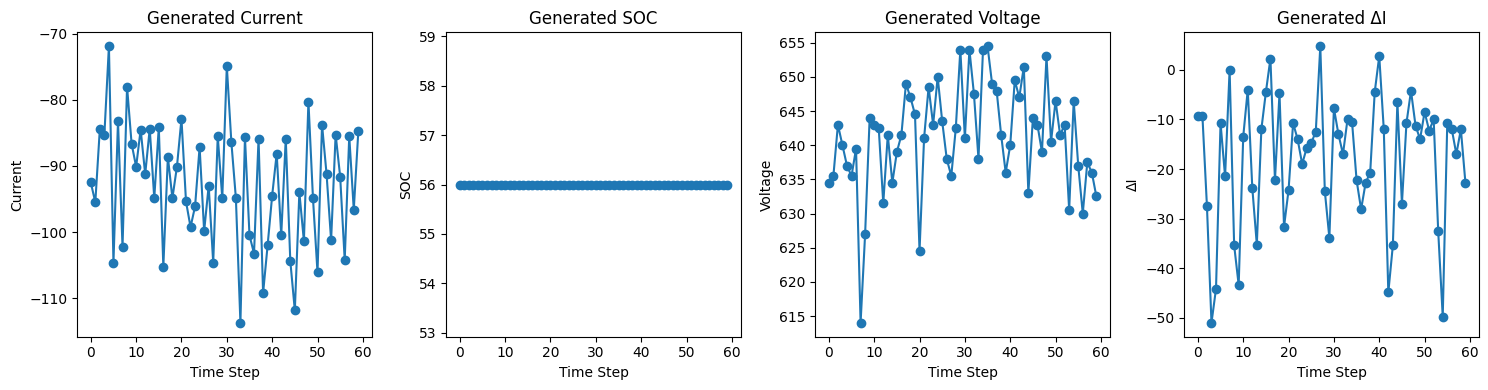

c:\Users\user\anaconda3\envs\hjjang\lib\site-packages\numpy\lib\function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
c:\Users\user\anaconda3\envs\hjjang\lib\site-packages\numpy\lib\function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


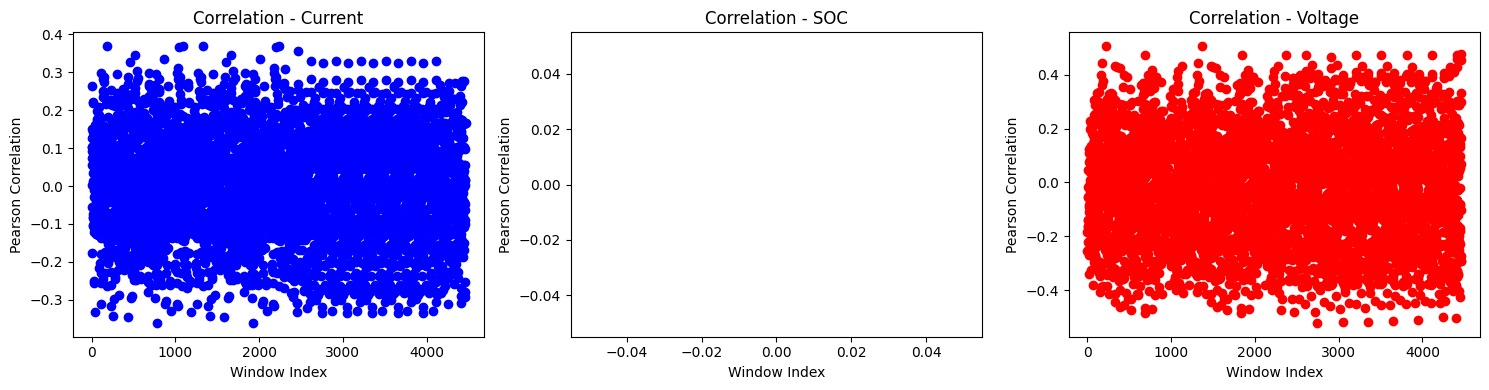

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

def denormalize_feature(data, feature_index, data_min, data_max):
    return data[..., feature_index] * (data_max[feature_index] - data_min[feature_index] + 1e-7) + data_min[feature_index]

def denorm_vector(vec, feature_index, data_min, data_max):
    return vec * (data_max[feature_index] - data_min[feature_index]) + data_min[feature_index]

# -------------------------------------------------------------------
# 수정된 combine_output 함수
# Generator 출력: [Current, ΔI, Voltage] (총 3채널)
# 조건(cond_sample, SOC)은 (batch, window_size, 1) 형태이며,
# 최종 ordering: [Current, SOC, Voltage, ΔI] (총 4채널)
# -------------------------------------------------------------------
def combine_output(dynamic, cond):
    # dynamic: (batch, window_size, 3) → [Current, ΔI, Voltage]
    current = dynamic[..., :1]         # (batch, window_size, 1): Current
    remaining = dynamic[..., 1:]         # (batch, window_size, 2): [ΔI, Voltage]
    cond = tf.cast(cond, dynamic.dtype)  # (batch, window_size, 1): SOC
    # 최종 생성 시퀀스: [Current, SOC, Voltage, ΔI]
    # remaining[..., -1:]는 Voltage, remaining[..., :1]는 ΔI
    voltage = remaining[..., -1:]
    delta = remaining[..., :1]
    return tf.concat([current, cond, voltage, delta], axis=-1)

# -------------------------------------------------------------------
# 생성된 시계열 샘플 확인 (검증용)
# -------------------------------------------------------------------
# 1. 임의의 노이즈 샘플: (1, window_size, latent_dim)
noise_sample = tf.random.normal([1, window_size, latent_dim])
# 2. 조건 샘플: all_sequences의 특정 샘플에서 SOC를 추출 (shape: (1, window_size, 1))
cond_sample = get_condition(all_sequences[500:501])
# 3. 조건부 Generator 실행: Generator는 3채널 출력, ordering: [Current, ΔI, Voltage]
latent_dynamic = generator_cond([noise_sample, cond_sample], training=False)
print("Latent dynamic.shape:", latent_dynamic.shape)  # 예상: (1, window_size, 3)
# 4. combine_output: 최종 생성 시퀀스 구성, ordering: [Current, SOC, Voltage, ΔI]
generated_sequence = combine_output(latent_dynamic, cond_sample)
print("Generated sequence shape:", generated_sequence.shape)  # 예상: (1, window_size, 4)

# 선택: 첫 번째 시퀀스 추출 (shape: (window_size, 4))
gen_seq = generated_sequence[0].numpy()

# 각 피처별 denormalization (피처 인덱스: 0: Current, 1: SOC, 2: Voltage, 3: ΔI)
gen_current_denorm = denormalize_feature(gen_seq, 0, data_min, data_max)
gen_soc_denorm     = denormalize_feature(gen_seq, 1, data_min, data_max)
gen_voltage_denorm = denormalize_feature(gen_seq, 2, data_min, data_max)
gen_deltaI_denorm  = denormalize_feature(gen_seq, 3, data_min, data_max)

# 각 피처별 생성 데이터 시각화 (원래 스케일)
plt.figure(figsize=(15,4))
plt.subplot(1,4,1)
plt.plot(gen_current_denorm, marker='o')
plt.title('Generated Current')
plt.xlabel('Time Step')
plt.ylabel('Current')

plt.subplot(1,4,2)
plt.plot(gen_soc_denorm, marker='o')
plt.title('Generated SOC')
plt.xlabel('Time Step')
plt.ylabel('SOC')

plt.subplot(1,4,3)
plt.plot(gen_voltage_denorm, marker='o')
plt.title('Generated Voltage')
plt.xlabel('Time Step')
plt.ylabel('Voltage')

plt.subplot(1,4,4)
plt.plot(gen_deltaI_denorm, marker='o')
plt.title('Generated ΔI')
plt.xlabel('Time Step')
plt.ylabel('ΔI')

plt.tight_layout()
plt.show()

# -------------------------------------------------------------------
# 각 슬라이딩 윈도우별 상관계수 계산
# 전체 슬라이딩 윈도우 (all_sequences)는 원본 4채널, 순서: [Current, SOC, Voltage, ΔI]
# 여기서는 [Current, SOC, Voltage]에 대해 상관계수를 계산합니다.
# -------------------------------------------------------------------
n_windows = all_sequences.shape[0]
corr_current = []
corr_soc = []
corr_voltage = []

for i in range(n_windows):
    window = all_sequences[i]  # shape: (window_size, 4)
    # 각 윈도우에서 원본 피처 추출 및 denormalize
    window_current = denormalize_feature(window, 0, data_min, data_max)
    window_soc     = denormalize_feature(window, 1, data_min, data_max)
    window_voltage = denormalize_feature(window, 2, data_min, data_max)

    # Pearson 상관계수 계산 (flatten 후)
    corr_current.append(np.corrcoef(window_current.ravel(), gen_current_denorm.ravel())[0, 1])
    corr_soc.append(np.corrcoef(window_soc.ravel(), gen_soc_denorm.ravel())[0, 1])
    corr_voltage.append(np.corrcoef(window_voltage.ravel(), gen_voltage_denorm.ravel())[0, 1])

# 상관계수 결과 플롯 (피처별)
x = np.arange(n_windows)

plt.figure(figsize=(15,4))
plt.subplot(1,3,1)
plt.scatter(x, corr_current, marker='o', color='blue')
plt.title('Correlation - Current')
plt.xlabel('Window Index')
plt.ylabel('Pearson Correlation')

plt.subplot(1,3,2)
plt.scatter(x, corr_soc, marker='o', color='green')
plt.title('Correlation - SOC')
plt.xlabel('Window Index')
plt.ylabel('Pearson Correlation')

plt.subplot(1,3,3)
plt.scatter(x, corr_voltage, marker='o', color='red')
plt.title('Correlation - Voltage')
plt.xlabel('Window Index')
plt.ylabel('Pearson Correlation')

plt.tight_layout()
plt.show()


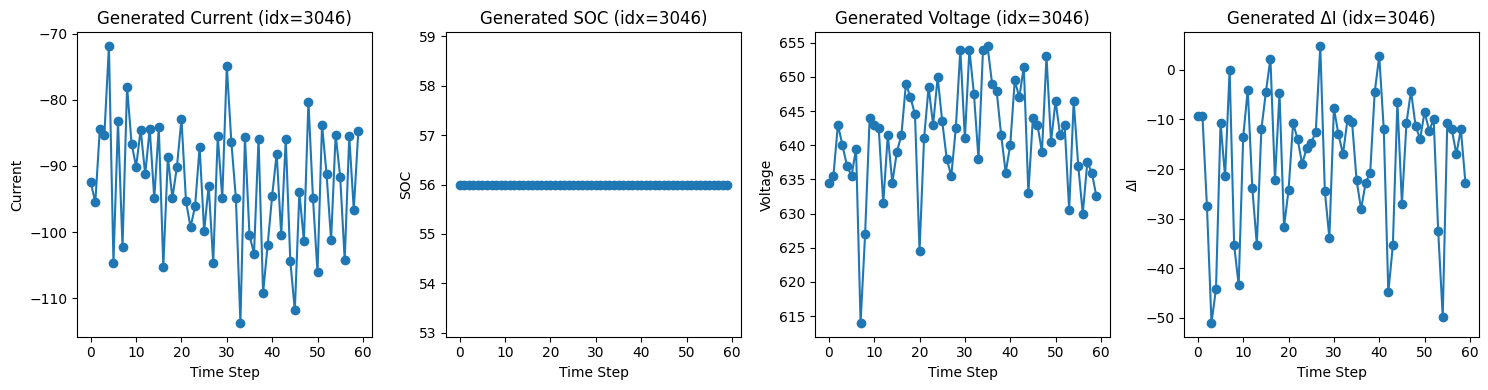

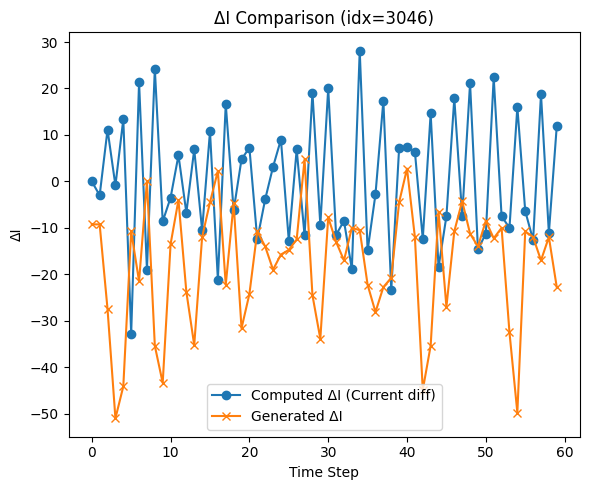

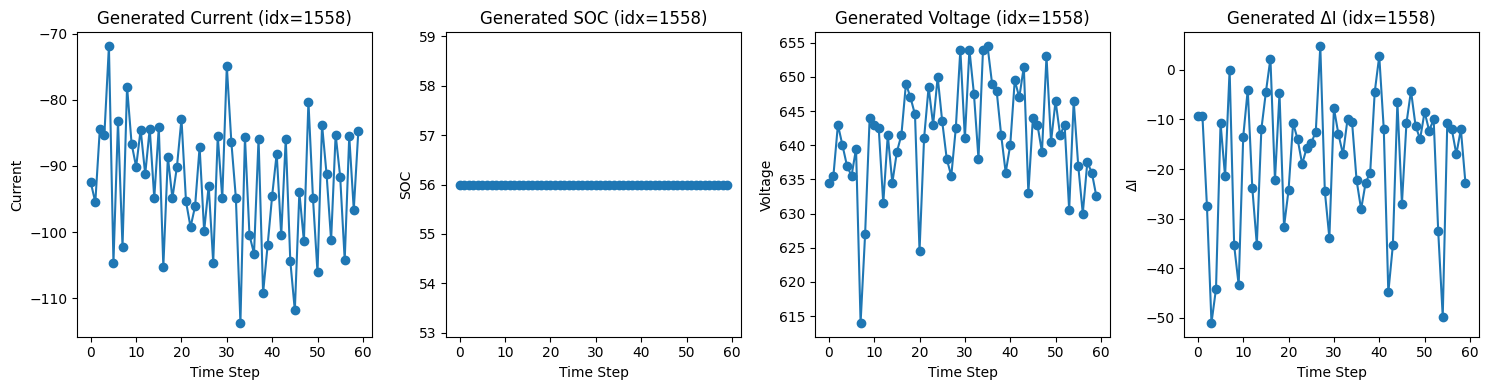

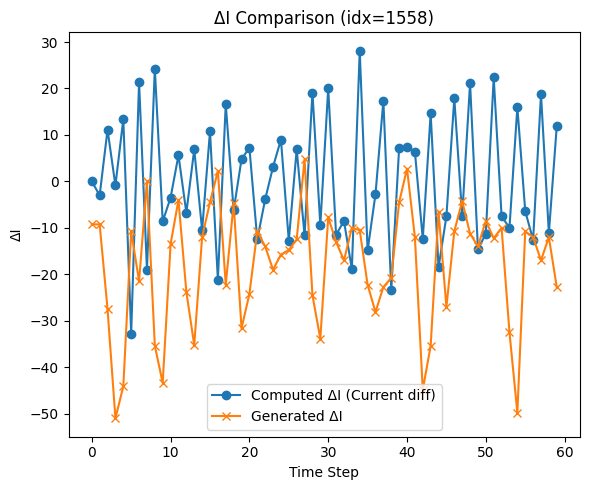

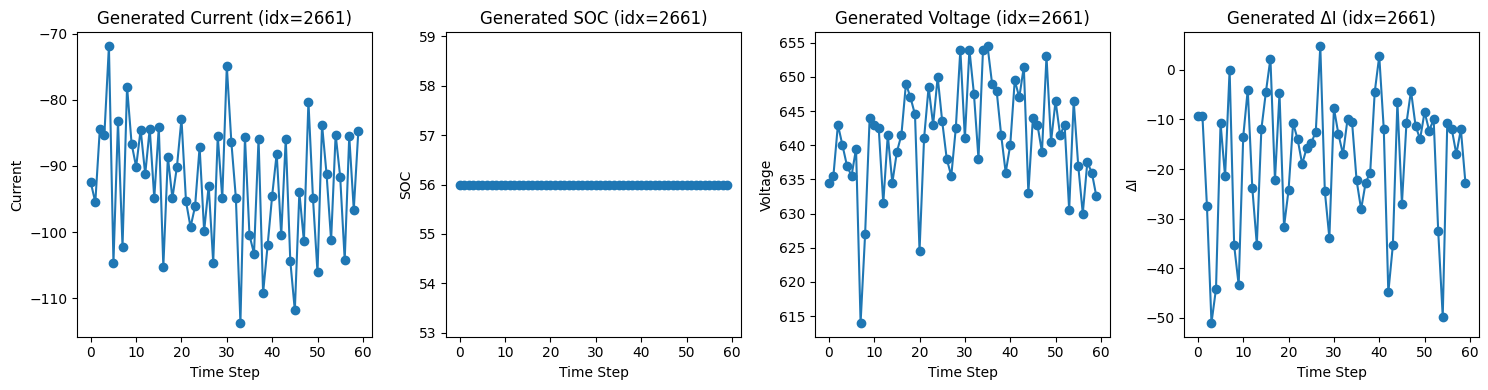

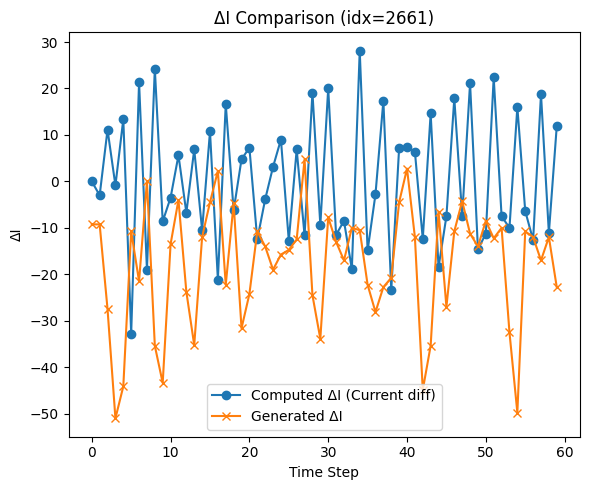

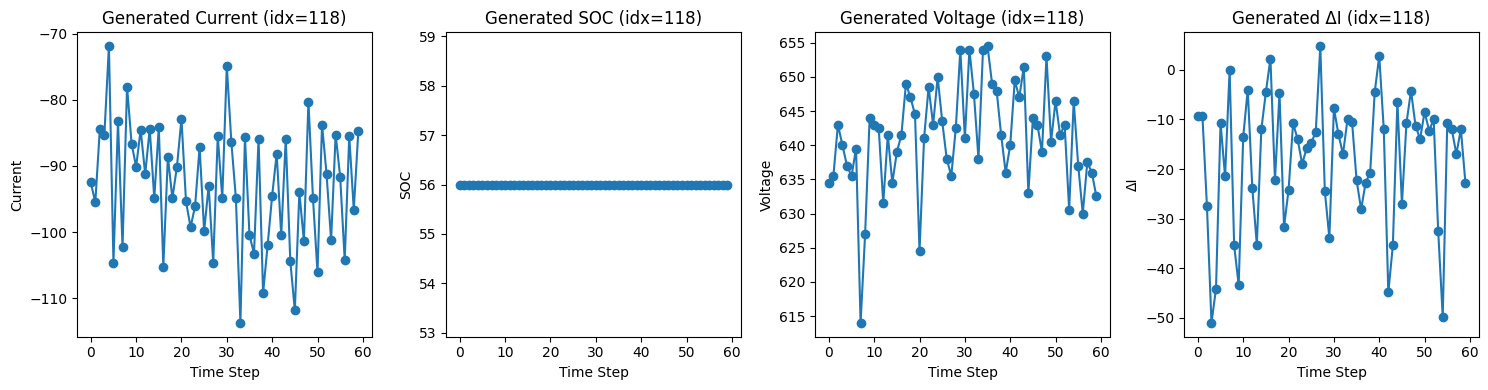

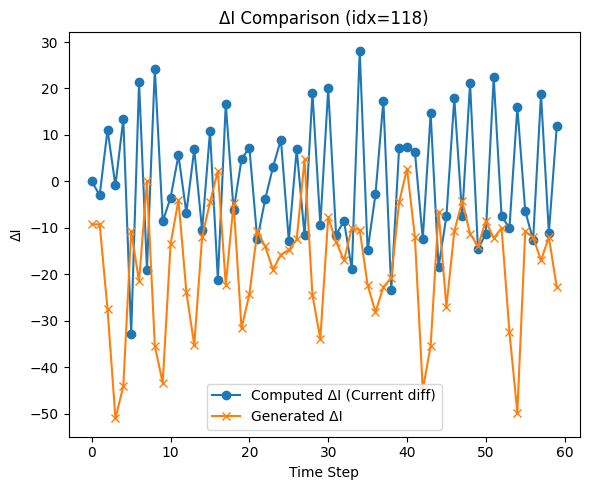

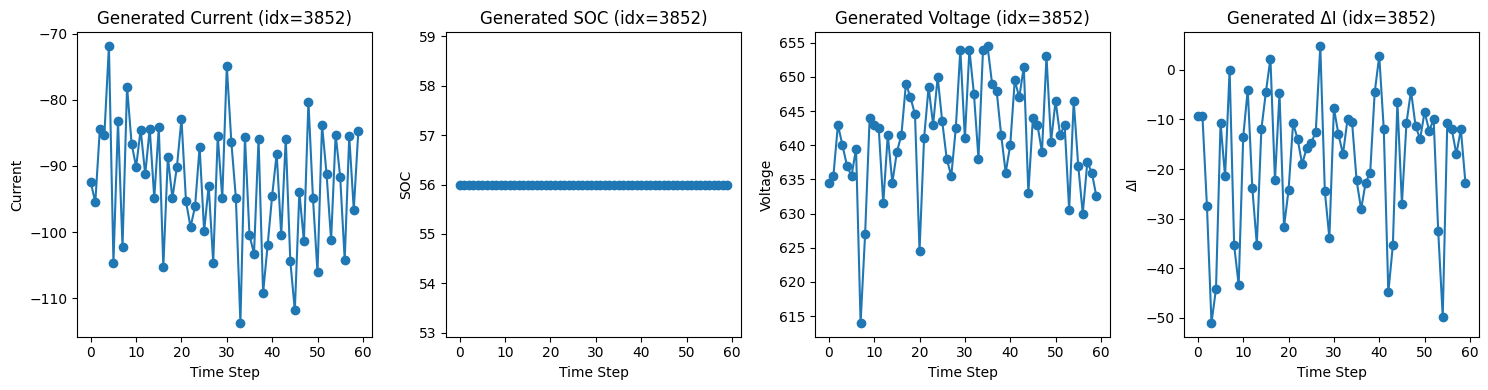

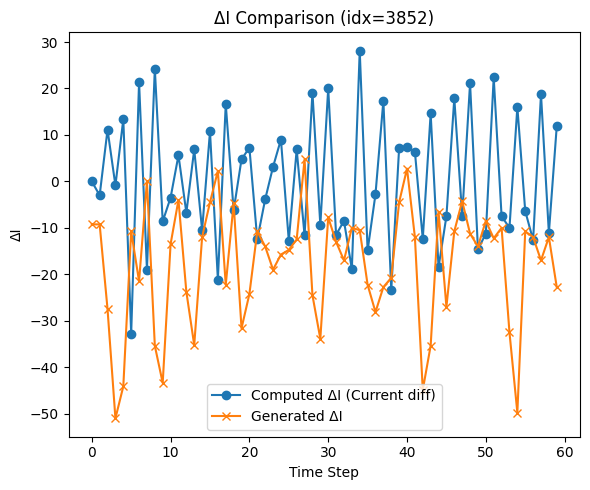

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# -------------------------------------------------------------------
# 5개의 랜덤 샘플에 대해 생성 결과 및 비교 플롯
# -------------------------------------------------------------------
num_plots = 5
random_indices = np.random.choice(len(all_sequences), size=num_plots, replace=False)

for idx in random_indices:
    gen_current_denorm = denormalize_feature(gen_seq, 0, data_min, data_max)
    gen_soc_denorm     = denormalize_feature(gen_seq, 1, data_min, data_max)
    gen_voltage_denorm = denormalize_feature(gen_seq, 2, data_min, data_max)
    gen_deltaI_denorm  = denormalize_feature(gen_seq, 3, data_min, data_max)

    plt.figure(figsize=(15,4))
    plt.subplot(1,4,1)
    plt.plot(gen_current_denorm, marker='o')
    plt.title(f'Generated Current (idx={idx})')
    plt.xlabel('Time Step')
    plt.ylabel('Current')

    plt.subplot(1,4,2)
    plt.plot(gen_soc_denorm, marker='o')
    plt.title(f'Generated SOC (idx={idx})')
    plt.xlabel('Time Step')
    plt.ylabel('SOC')

    plt.subplot(1,4,3)
    plt.plot(gen_voltage_denorm, marker='o')
    plt.title(f'Generated Voltage (idx={idx})')
    plt.xlabel('Time Step')
    plt.ylabel('Voltage')

    plt.subplot(1,4,4)
    plt.plot(gen_deltaI_denorm, marker='o')
    plt.title(f'Generated ΔI (idx={idx})')
    plt.xlabel('Time Step')
    plt.ylabel('ΔI')

    plt.tight_layout()
    plt.show()

    # 추가: Generated Current의 시간차분을 계산하여 ΔI와 비교
    computed_deltaI = np.diff(gen_current_denorm, prepend=gen_current_denorm[0])

    plt.figure(figsize=(6,5))
    plt.plot(computed_deltaI, marker='o', label='Computed ΔI (Current diff)')
    plt.plot(gen_deltaI_denorm, marker='x', label='Generated ΔI')
    plt.title(f'ΔI Comparison (idx={idx})')
    plt.xlabel('Time Step')
    plt.ylabel('ΔI')
    plt.legend()
    plt.tight_layout()
    plt.show()

[Sample idx=2366] latent_dynamic.shape = (1, 60, 3)
[Sample idx=2366] generated_sequence.shape = (1, 60, 4)
[Sample idx=2366] Teacher(1D-CNN) vs. GAN Voltage: MSE=7380.0000, Corr=0.0029
[Sample idx=2366] Teacher(LSTM)   vs. GAN Voltage: MSE=6652.0000, Corr=-0.0014


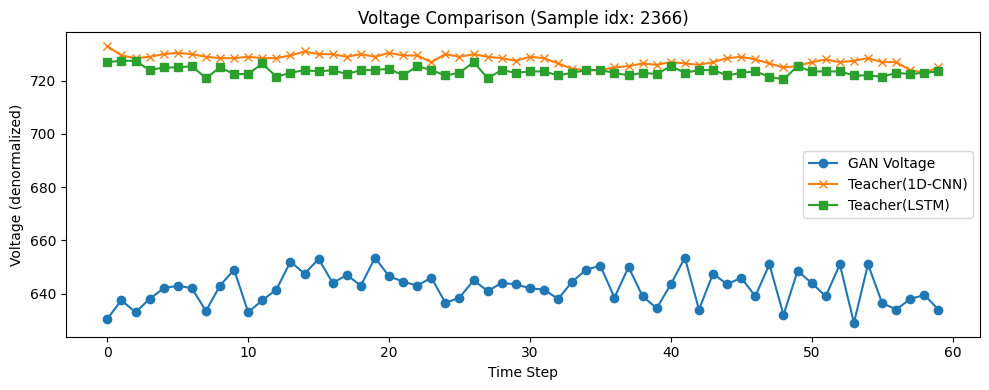

[Sample idx=2789] latent_dynamic.shape = (1, 60, 3)
[Sample idx=2789] generated_sequence.shape = (1, 60, 4)
[Sample idx=2789] Teacher(1D-CNN) vs. GAN Voltage: MSE=4520.0000, Corr=0.1139
[Sample idx=2789] Teacher(LSTM)   vs. GAN Voltage: MSE=3338.0000, Corr=0.1128


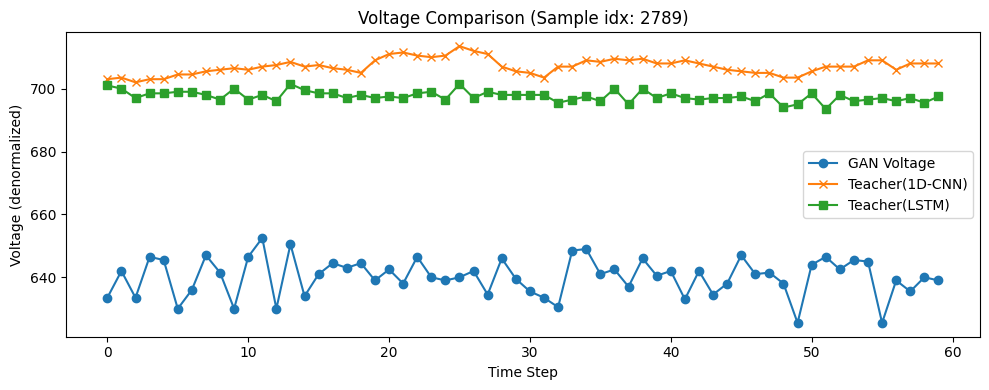

[Sample idx=155] latent_dynamic.shape = (1, 60, 3)
[Sample idx=155] generated_sequence.shape = (1, 60, 4)
[Sample idx=155] Teacher(1D-CNN) vs. GAN Voltage: MSE=7956.0000, Corr=-0.1658
[Sample idx=155] Teacher(LSTM)   vs. GAN Voltage: MSE=7080.0000, Corr=0.1941


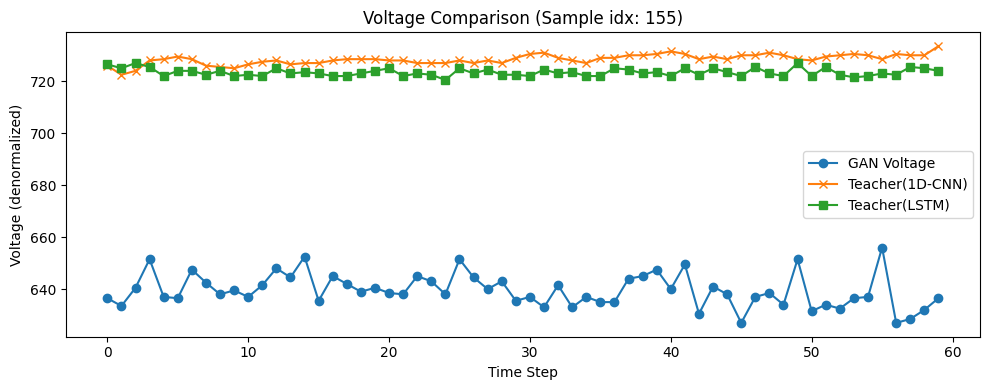

[Sample idx=2441] latent_dynamic.shape = (1, 60, 3)
[Sample idx=2441] generated_sequence.shape = (1, 60, 4)
[Sample idx=2441] Teacher(1D-CNN) vs. GAN Voltage: MSE=7020.0000, Corr=-0.0201
[Sample idx=2441] Teacher(LSTM)   vs. GAN Voltage: MSE=6504.0000, Corr=-0.0649


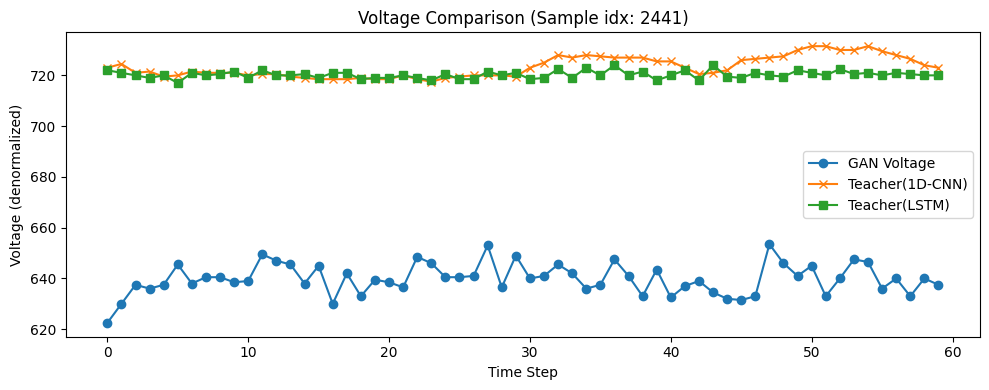

[Sample idx=1419] latent_dynamic.shape = (1, 60, 3)
[Sample idx=1419] generated_sequence.shape = (1, 60, 4)
[Sample idx=1419] Teacher(1D-CNN) vs. GAN Voltage: MSE=5896.0000, Corr=-0.0585
[Sample idx=1419] Teacher(LSTM)   vs. GAN Voltage: MSE=5180.0000, Corr=0.0950


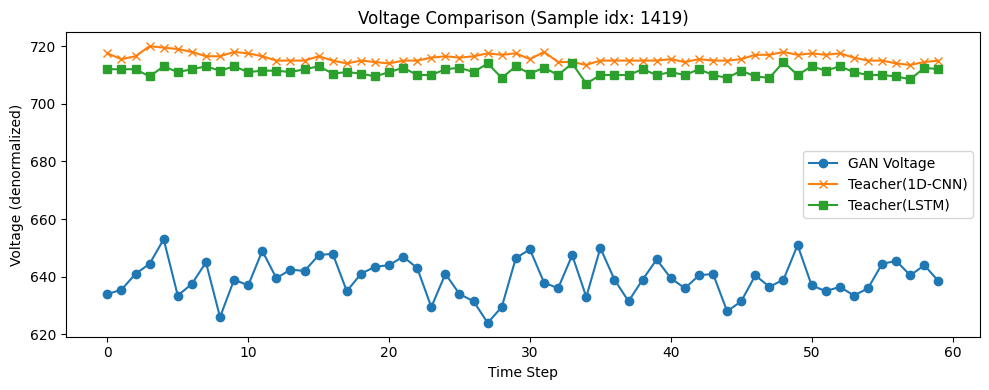

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# 가정:
# - all_sequences: (N, window_size, 4) → 채널 순서: [Current, SOC, Voltage, ΔI]
# - get_condition: SOC 추출 함수
# - generator_cond: Generator 모델 (3채널 출력: [Current, ΔI, Voltage])
# - combine_output: 최종 4채널 ([Current, SOC, Voltage, ΔI])를 만드는 함수
# - teacher_model, teacher_model_2: Teacher 모델 (freeze 상태), 입력: [Current, SOC, ΔI], 출력: Voltage
# - data_min, data_max: 각 채널([Current, SOC, Voltage, ΔI])의 최소·최대값
# - latent_dim, window_size: 이미 정의됨

def denorm_vector(vec, feature_index, data_min, data_max):
    # vec: 1D (window_size,)
    return vec * (data_max[feature_index] - data_min[feature_index] + 1e-7) + data_min[feature_index]

num_plots = 5
indices = np.random.choice(len(all_sequences), size=num_plots, replace=False)

voltage_model = teacher_model       # 1D-CNN Teacher
voltage_model_2 = teacher_model_2   # LSTM Teacher
voltage_model.trainable = False
voltage_model_2.trainable = False

for idx in indices:
    # (1) 해당 샘플 시퀀스 (shape: (1, window_size, 4))에서 SOC 추출
    sample_seq = all_sequences[idx:idx+1]  # shape: (1, window_size, 4)
    cond_sample = get_condition(sample_seq)  # (1, window_size, 1)

    # (2) 임의 노이즈 생성 (shape: (1, window_size, latent_dim))
    noise_sample = tf.random.normal([1, window_size, latent_dim])

    # (3) Generator 실행: Generator는 3채널 출력, ordering: [Current, ΔI, Voltage]
    latent_dynamic = generator_cond([noise_sample, cond_sample], training=False)
    print(f"[Sample idx={idx}] latent_dynamic.shape =", latent_dynamic.shape)  # 예상: (1, window_size, 3)

    # (4) combine_output: 최종 생성 시퀀스 구성, ordering: [Current, SOC, Voltage, ΔI]
    generated_sequence = combine_output(latent_dynamic, cond_sample)
    print(f"[Sample idx={idx}] generated_sequence.shape =", generated_sequence.shape)  # 예상: (1, window_size, 4)

    # (5) Teacher 모델 입력: 채널 인덱스 [0,1,3] → [Current, SOC, ΔI]
    teacher_input = tf.gather(generated_sequence, indices=[0,1,3], axis=-1)

    # (6) Teacher 모델 예측
    # 1D-CNN Teacher
    teacher_pred1 = voltage_model(teacher_input, training=False)   # (1, window_size, 1)
    teacher_pred1 = tf.squeeze(teacher_pred1, axis=-1).numpy()[0]  # (window_size,)
    # LSTM Teacher
    teacher_pred2 = voltage_model_2(teacher_input, training=False)  # (1, window_size, 1)
    teacher_pred2 = tf.squeeze(teacher_pred2, axis=-1).numpy()[0]   # (window_size,)

    # (7) GAN이 생성한 전압: 채널 2 (shape: (window_size,)) → generated_sequence의 채널 순서: [Current, SOC, Voltage, ΔI]
    gan_voltage = generated_sequence[0, :, 2].numpy()

    # (8) Denormalize (Voltage → feature_index=2)
    gan_voltage_denorm = denorm_vector(gan_voltage, 2, data_min, data_max)
    teacher_voltage_denorm1 = denorm_vector(teacher_pred1, 2, data_min, data_max)
    teacher_voltage_denorm2 = denorm_vector(teacher_pred2, 2, data_min, data_max)

    # (9) 평가 (MSE, Corr)
    mse_teacher1 = np.mean((gan_voltage_denorm - teacher_voltage_denorm1)**2)
    corr_teacher1 = np.corrcoef(gan_voltage_denorm, teacher_voltage_denorm1)[0, 1]
    mse_teacher2 = np.mean((gan_voltage_denorm - teacher_voltage_denorm2)**2)
    corr_teacher2 = np.corrcoef(gan_voltage_denorm, teacher_voltage_denorm2)[0, 1]

    print(f"[Sample idx={idx}] Teacher(1D-CNN) vs. GAN Voltage: MSE={mse_teacher1:.4f}, Corr={corr_teacher1:.4f}")
    print(f"[Sample idx={idx}] Teacher(LSTM)   vs. GAN Voltage: MSE={mse_teacher2:.4f}, Corr={corr_teacher2:.4f}")

    # (10) 시각화
    plt.figure(figsize=(10,4))
    plt.plot(gan_voltage_denorm, marker='o', label='GAN Voltage')
    plt.plot(teacher_voltage_denorm1, marker='x', label='Teacher(1D-CNN)')
    plt.plot(teacher_voltage_denorm2, marker='s', label='Teacher(LSTM)')
    plt.title(f"Voltage Comparison (Sample idx: {idx})")
    plt.xlabel("Time Step")
    plt.ylabel("Voltage (denormalized)")
    plt.legend()
    plt.tight_layout()
    plt.show()



Selected window indices: [ 354 3220 4070  522 3226]
Loading generator model from: C:\Users\user\Desktop\JANG\code\AI\250322\JSAE_generator_epoch_250322_600.h5


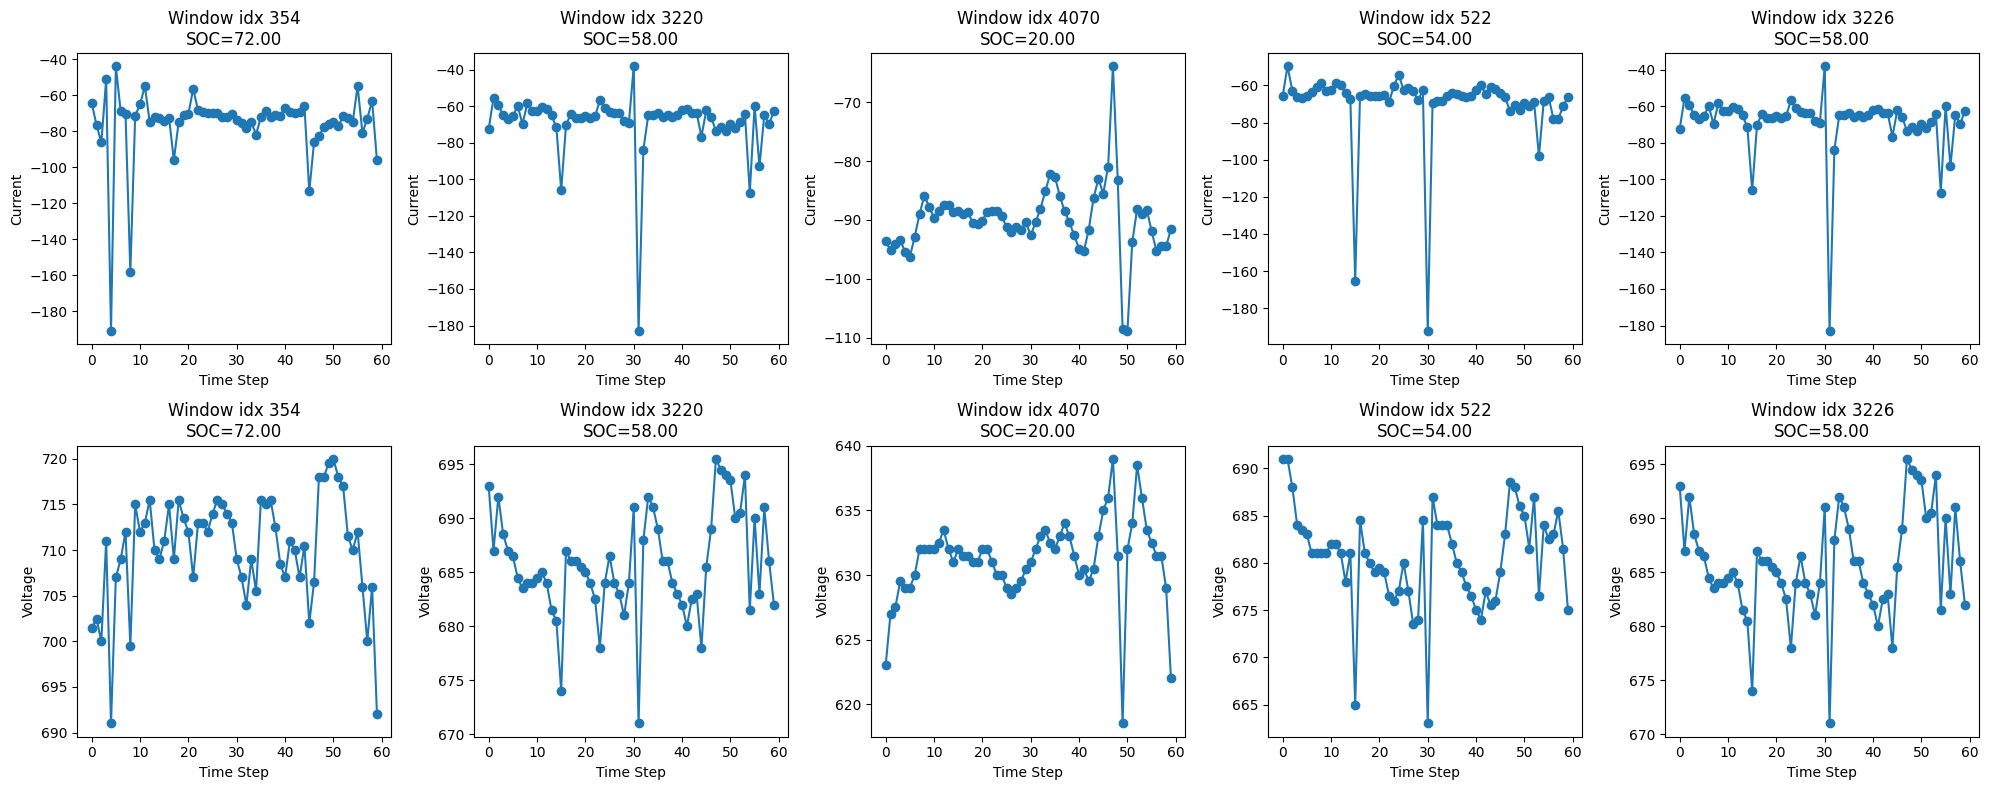

In [ ]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# --- 전역 설정 ---
# all_sequences: (N, window_size, 4) → [전류, SOC, 전압, ΔI]
# window_size, latent_dim, data_min, data_max, generator_cond, get_condition, denormalize_feature 등이 이미 정의되어 있다고 가정

# 예시: 단일 Generator 모델 경로 (250317 모델)
generator_path = r"C:\Users\user\Desktop\JANG\code\AI\250322\JSAE_generator_epoch_250322_600.h5"
# generator_path = r"C:\Users\user\Desktop\JANG\code\AI\250322\generator_final.h5"

# 원하는 윈도우 인덱스 랜덤 선택 (매 실행마다 변경)
random_indices = np.random.choice(len(all_sequences), size=5, replace=False)
print("Selected window indices:", random_indices)

# 단일 Generator 모델 로드
print(f"Loading generator model from: {generator_path}")
generator_model = load_model(generator_path)

# 고정 noise 샘플 (모든 조건에 동일하게 사용)
noise_fixed = tf.random.normal([1, window_size, latent_dim])

# 각 선택된 윈도우에서 SOC 추출 및 평균 계산
cond_list = []
soc_last_list = []  # 각 윈도우의 마지막 SOC (denormalized)
for idx in random_indices:
    real_window = all_sequences[idx]  # shape: (window_size, 4)
    # SOC 채널(인덱스 1) 추출 → shape: (window_size, 1)
    soc = real_window[:, 1:2]
    soc = soc[np.newaxis, ...]         # (1, window_size, 1)
    cond_list.append(soc)
    # 윈도우의 마지막 SOC 값 사용 (학습 시 사용한 조건과 동일)
    last_soc = soc[0, -1, 0]  # 마지막 time step의 SOC (scalar)
    last_soc_denorm = last_soc * (data_max[1] - data_min[1] + 1e-7) + data_min[1]
    soc_last_list.append(last_soc_denorm)

# 결과 저장: 각 선택된 윈도우에 대해 Generator가 생성한 전류와 전압 추출
# 생성된 최종 시퀀스의 ordering: [전류, SOC, 전압, ΔI]
results_current = []
results_voltage = []
for soc_cond in cond_list:
    # Generator 실행: Generator는 3채널 출력, ordering: [전류, ΔI, 전압]
    latent_output = generator_model([noise_fixed, soc_cond], training=False)  # (1, window_size, 3)
    generated_seq = combine_output(latent_output, soc_cond)  # (1, window_size, 4)
    # 전류 (index=0)와 전압 (index=2) 추출
    gen_current = generated_seq[0, :, 0].numpy()
    gen_voltage = generated_seq[0, :, 2].numpy()
    results_current.append(gen_current)
    results_voltage.append(gen_voltage)

# Denormalize: 전류는 인덱스 0, 전압은 인덱스 2 기준으로 복원
def denorm(arr, feature_index):
    # arr: 1D array (window_size,)
    return arr * (data_max[feature_index] - data_min[feature_index] + 1e-7) + data_min[feature_index]

results_current_denorm = []
results_voltage_denorm = []
for curr, volt in zip(results_current, results_voltage):
    denorm_current = denorm(curr, 0)
    denorm_voltage = denorm(volt, 2)
    results_current_denorm.append(denorm_current)
    results_voltage_denorm.append(denorm_voltage)

# 플롯: 2행 x 5열 subplot (첫 행: 전류, 두 번째 행: 전압)
num_windows = len(random_indices)
plt.figure(figsize=(num_windows * 4, 8))
for i, idx in enumerate(random_indices):
    # 전류 플롯 (첫 번째 행)
    plt.subplot(2, num_windows, i+1)
    plt.plot(results_current_denorm[i], marker='o', linestyle='-')
    plt.title(f"Window idx {idx}\nSOC={soc_last_list[i]:.2f}")
    plt.xlabel("Time Step")
    plt.ylabel("Current")

    # 전압 플롯 (두 번째 행)
    plt.subplot(2, num_windows, num_windows + i + 1)
    plt.plot(results_voltage_denorm[i], marker='o', linestyle='-')
    plt.title(f"Window idx {idx}\nSOC={soc_last_list[i]:.2f}")
    plt.xlabel("Time Step")
    plt.ylabel("Voltage")

plt.tight_layout()
plt.show()



Selected window indices: [1860 3356 3413 3874 1329]


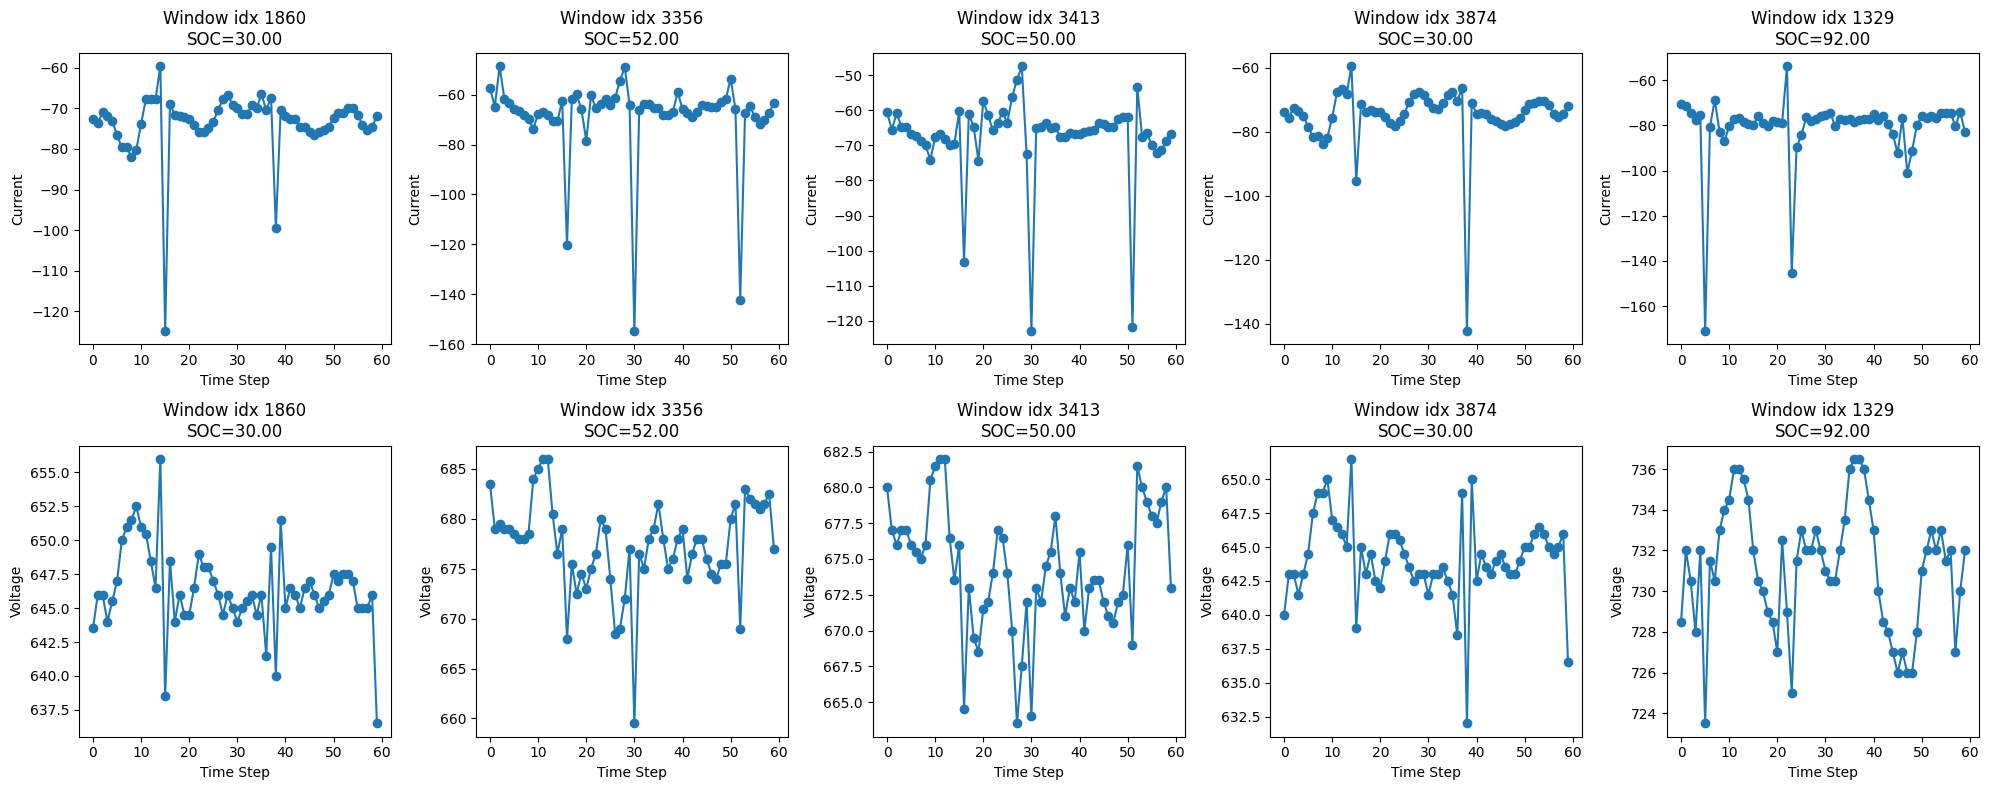

In [ ]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# --- 전역 설정 ---
# all_sequences: (N, window_size, 4) → [전류, SOC, 전압, ΔI]
# window_size, latent_dim, data_min, data_max, generator_cond, get_condition, denormalize_feature 등이 이미 정의되어 있다고 가정

# 예시: 단일 Generator 모델 경로 (250317 모델)

# 원하는 윈도우 인덱스 랜덤 선택 (매 실행마다 변경)
random_indices = np.random.choice(len(all_sequences), size=5, replace=False)
print("Selected window indices:", random_indices)

# 고정 noise 샘플 (모든 조건에 동일하게 사용)
noise_fixed = tf.random.normal([1, window_size, latent_dim])

# 각 선택된 윈도우에서 SOC 추출 및 평균 계산
cond_list = []
soc_last_list = []  # 각 윈도우의 마지막 SOC (denormalized)
for idx in random_indices:
    real_window = all_sequences[idx]  # shape: (window_size, 4)
    # SOC 채널(인덱스 1) 추출 → shape: (window_size, 1)
    soc = real_window[:, 1:2]
    soc = soc[np.newaxis, ...]         # (1, window_size, 1)
    cond_list.append(soc)
    # 윈도우의 마지막 SOC 값 사용 (학습 시 사용한 조건과 동일)
    last_soc = soc[0, -1, 0]  # 마지막 time step의 SOC (scalar)
    last_soc_denorm = last_soc * (data_max[1] - data_min[1] + 1e-7) + data_min[1]
    soc_last_list.append(last_soc_denorm)

# 결과 저장: 각 선택된 윈도우에 대해 Generator가 생성한 전류와 전압 추출
# 생성된 최종 시퀀스의 ordering: [전류, SOC, 전압, ΔI]
results_current = []
results_voltage = []
for soc_cond in cond_list:
    # Generator 실행: Generator는 3채널 출력, ordering: [전류, ΔI, 전압]
    latent_output = generator_model([noise_fixed, soc_cond], training=False)  # (1, window_size, 3)
    generated_seq = combine_output(latent_output, soc_cond)  # (1, window_size, 4)
    # 전류 (index=0)와 전압 (index=2) 추출
    gen_current = generated_seq[0, :, 0].numpy()
    gen_voltage = generated_seq[0, :, 2].numpy()
    results_current.append(gen_current)
    results_voltage.append(gen_voltage)

# Denormalize: 전류는 인덱스 0, 전압은 인덱스 2 기준으로 복원
def denorm(arr, feature_index):
    # arr: 1D array (window_size,)
    return arr * (data_max[feature_index] - data_min[feature_index] + 1e-7) + data_min[feature_index]

results_current_denorm = []
results_voltage_denorm = []
for curr, volt in zip(results_current, results_voltage):
    denorm_current = denorm(curr, 0)
    denorm_voltage = denorm(volt, 2)
    results_current_denorm.append(denorm_current)
    results_voltage_denorm.append(denorm_voltage)

# 플롯: 2행 x 5열 subplot (첫 행: 전류, 두 번째 행: 전압)
num_windows = len(random_indices)
plt.figure(figsize=(num_windows * 4, 8))
for i, idx in enumerate(random_indices):
    # 전류 플롯 (첫 번째 행)
    plt.subplot(2, num_windows, i+1)
    plt.plot(results_current_denorm[i], marker='o', linestyle='-')
    plt.title(f"Window idx {idx}\nSOC={soc_last_list[i]:.2f}")
    plt.xlabel("Time Step")
    plt.ylabel("Current")

    # 전압 플롯 (두 번째 행)
    plt.subplot(2, num_windows, num_windows + i + 1)
    plt.plot(results_voltage_denorm[i], marker='o', linestyle='-')
    plt.title(f"Window idx {idx}\nSOC={soc_last_list[i]:.2f}")
    plt.xlabel("Time Step")
    plt.ylabel("Voltage")

plt.tight_layout()
plt.show()


Selected window index: 922
SOC (denormalized): tf.Tensor(20.0, shape=(), dtype=float64)


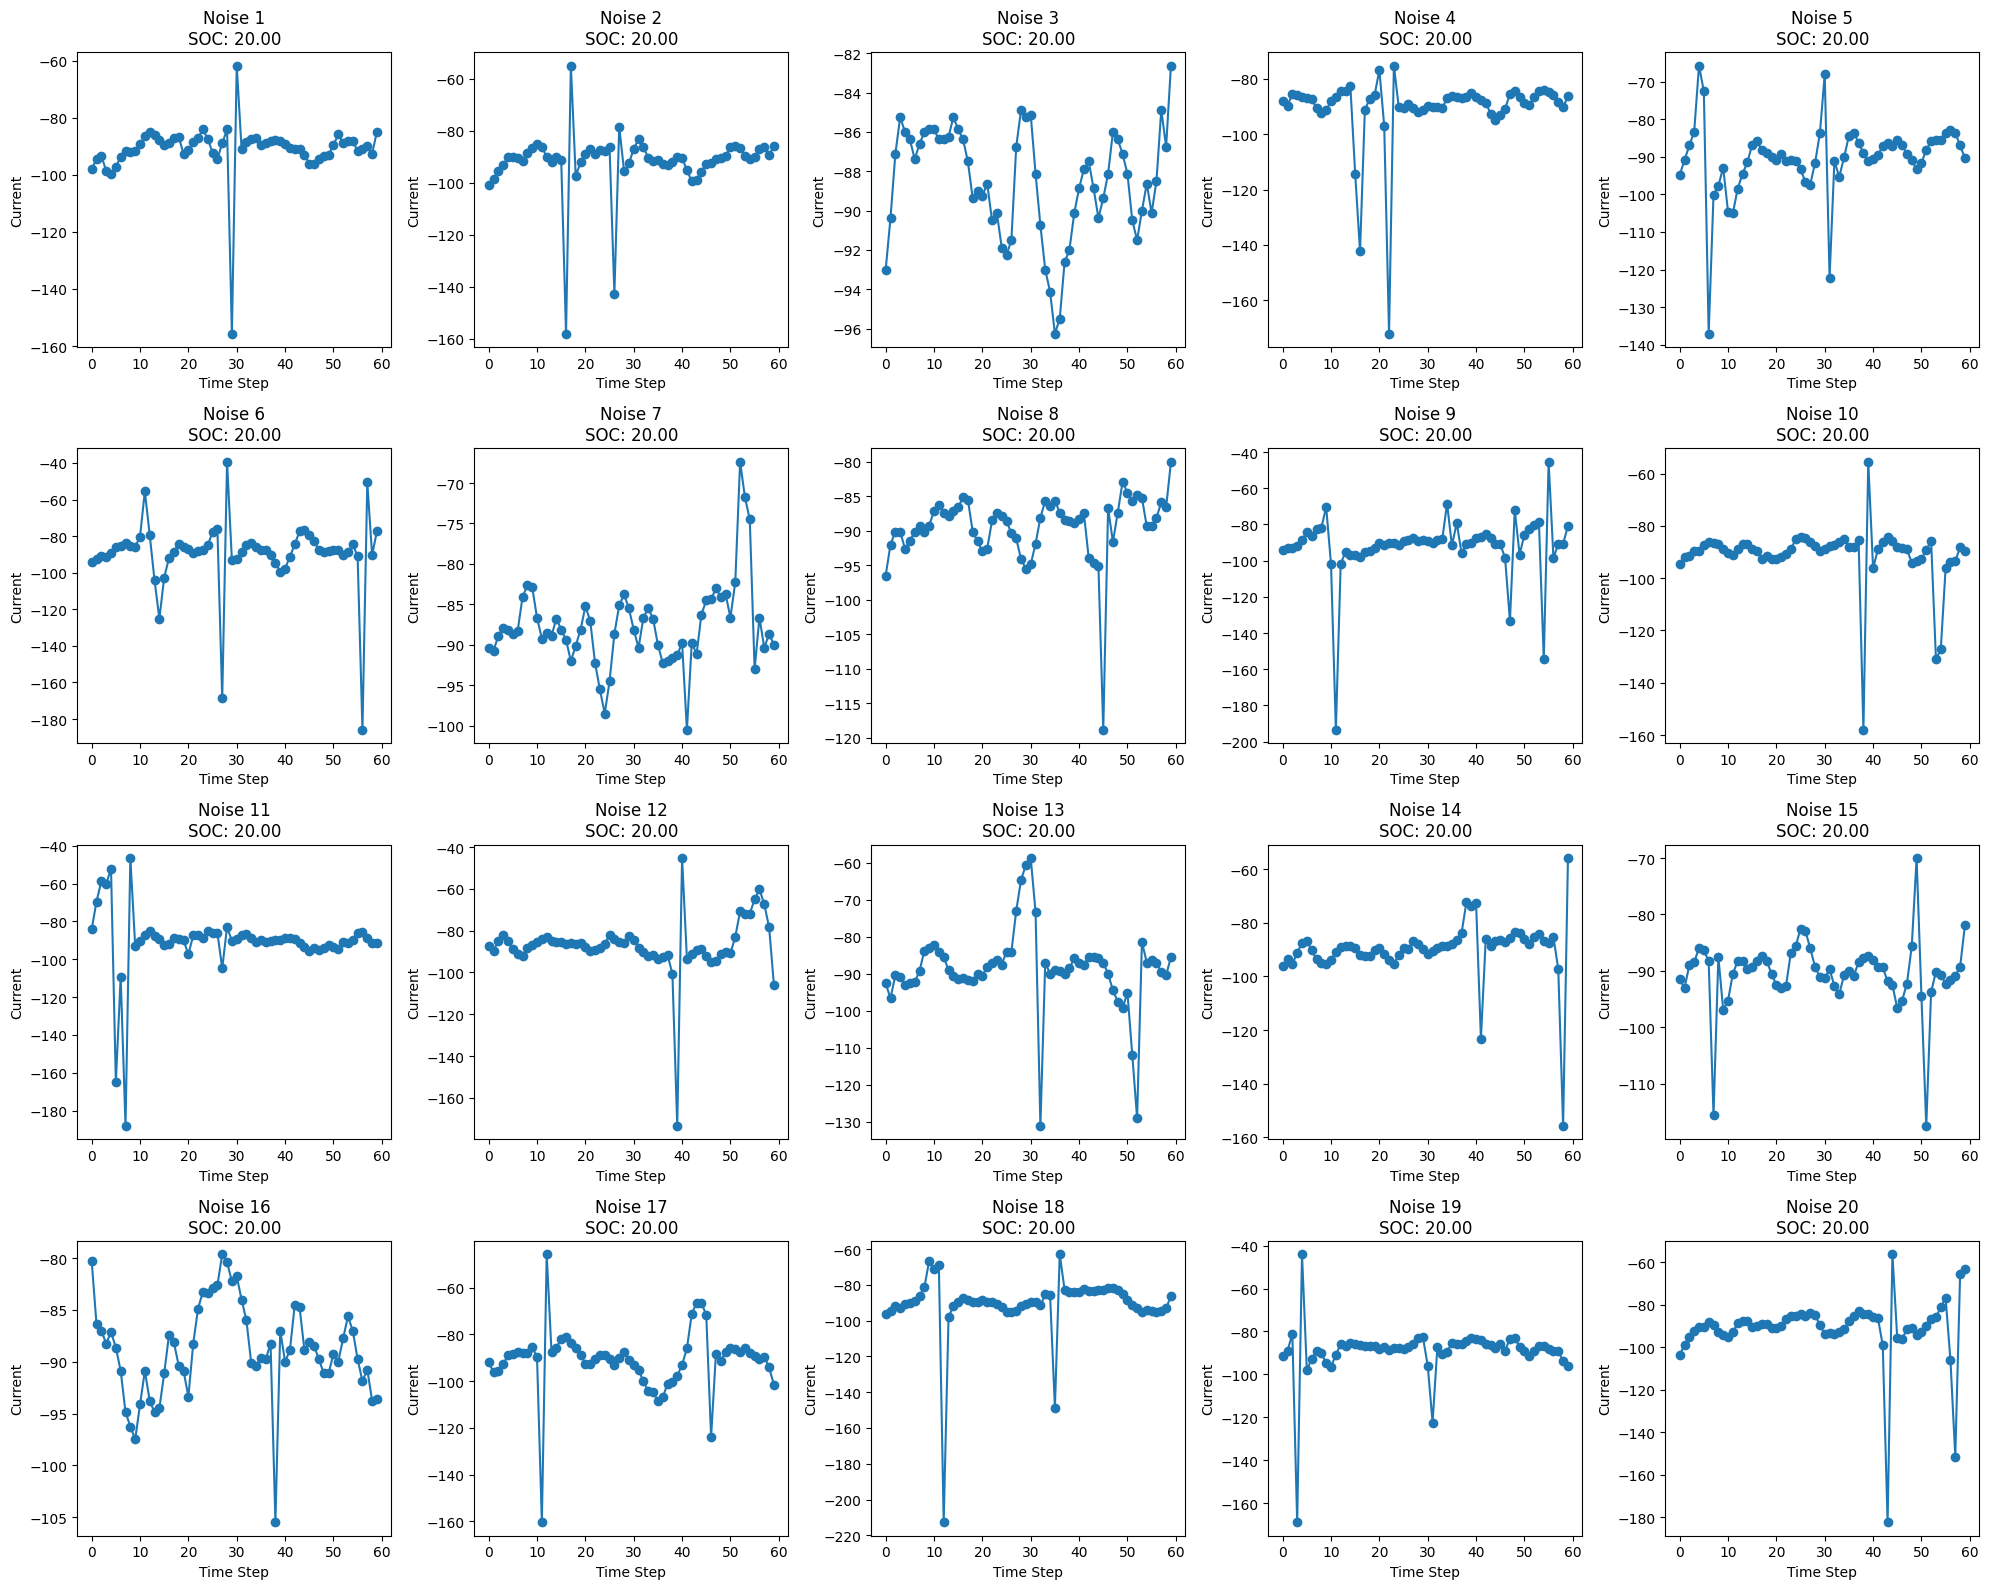

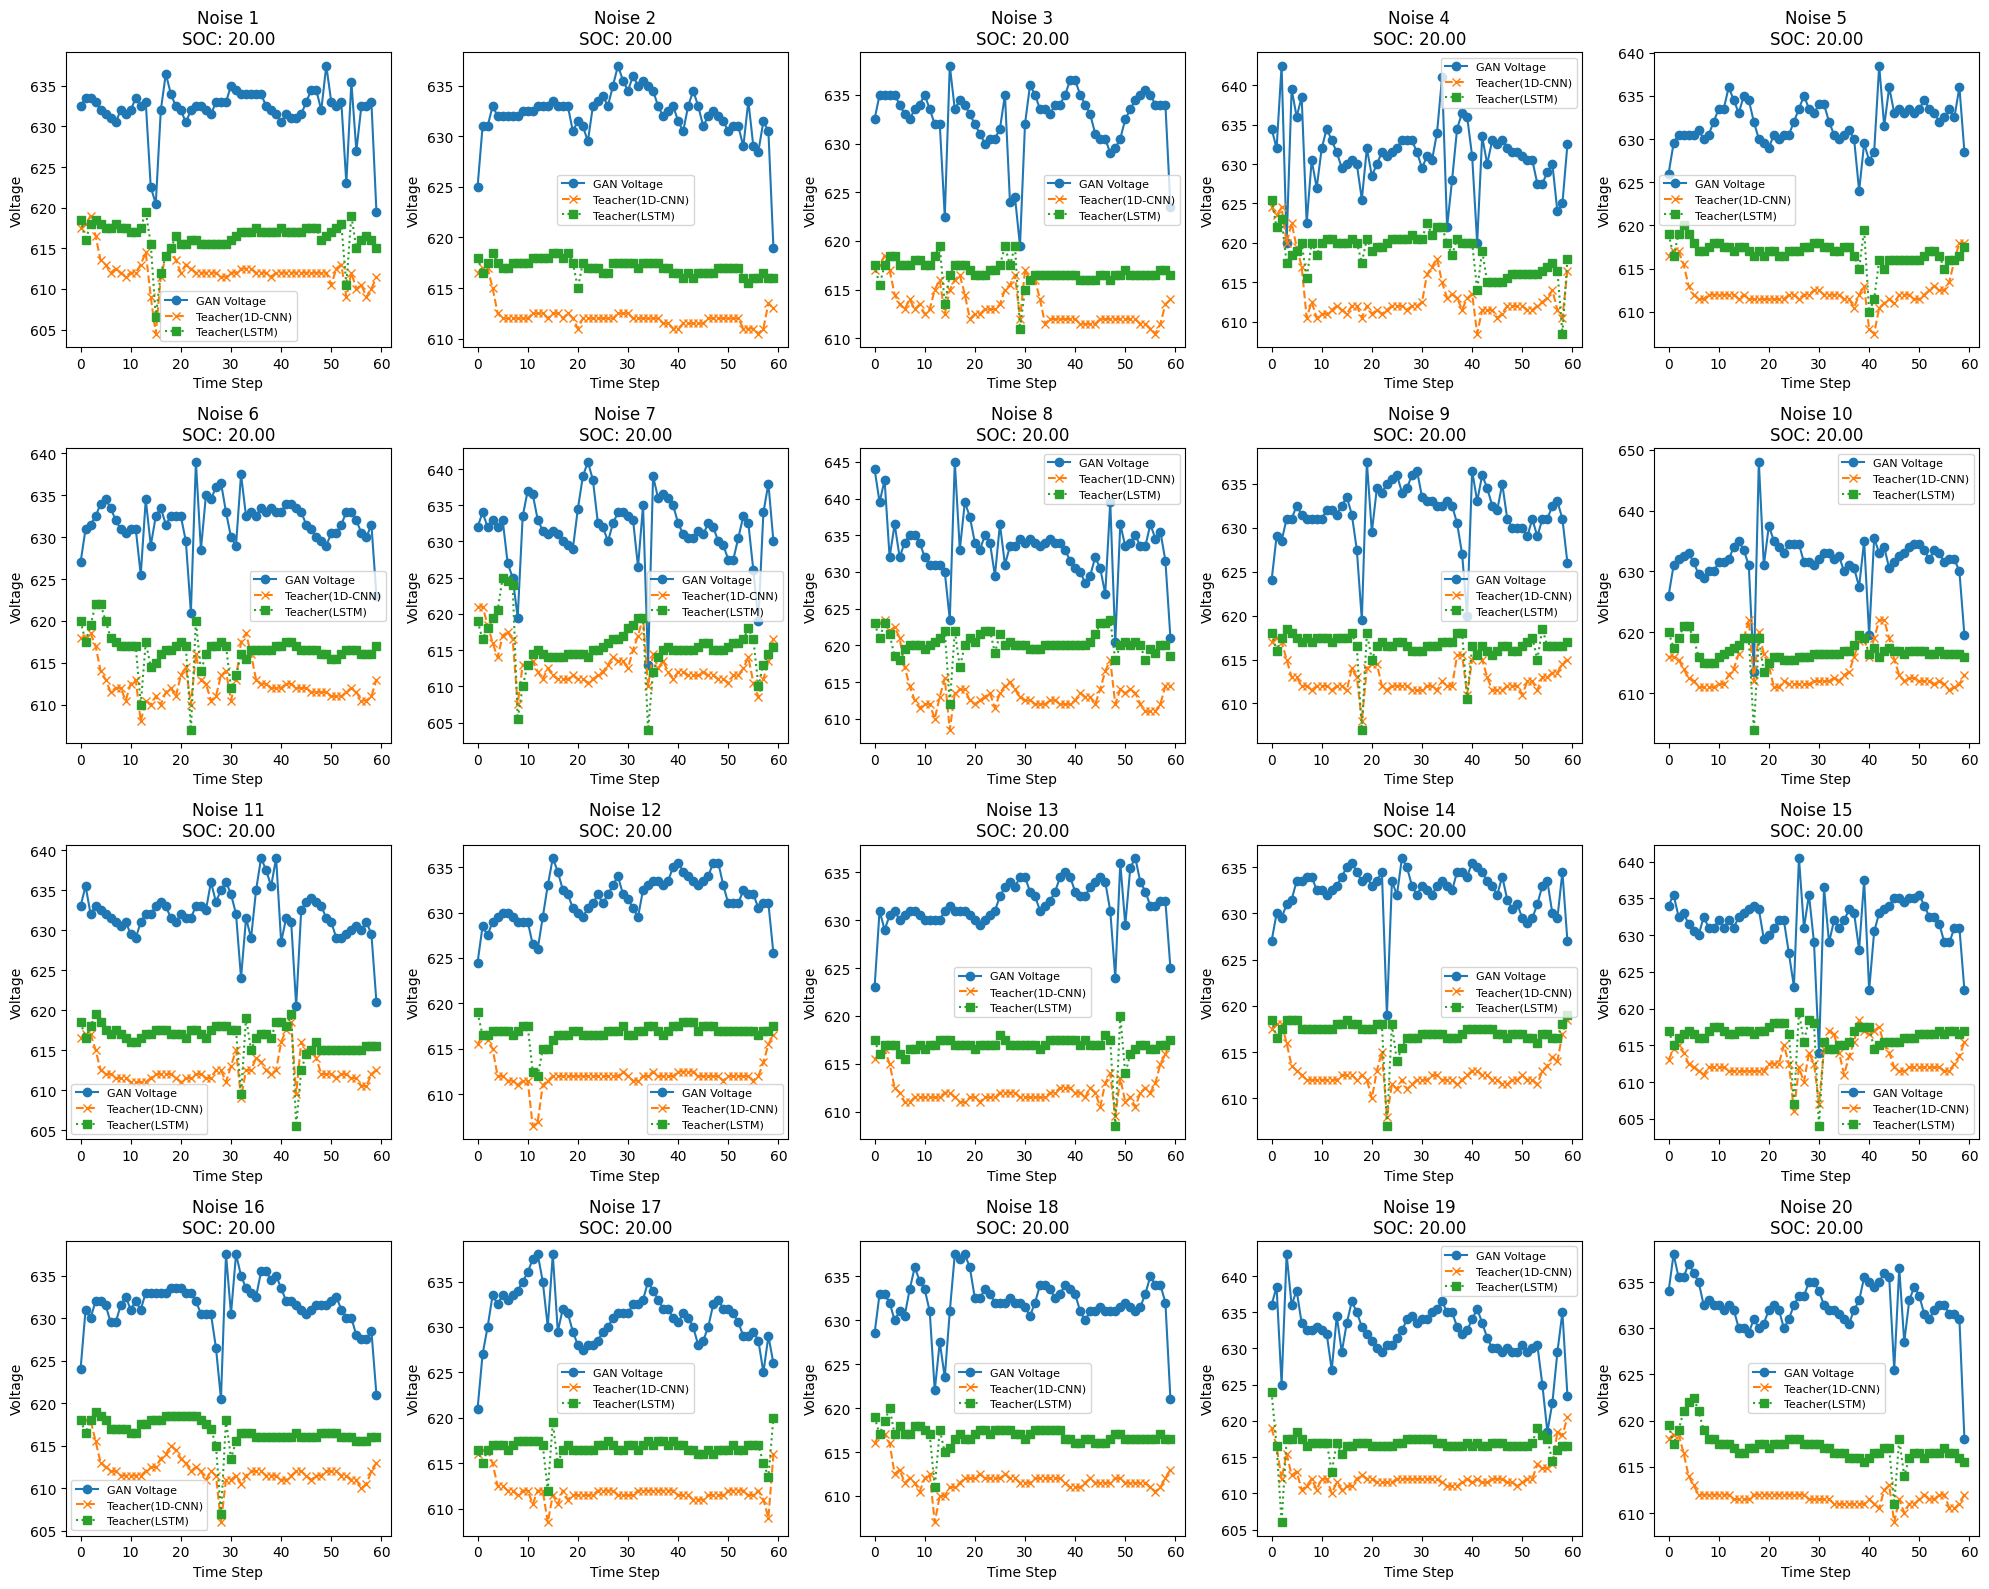

In [ ]:
import matplotlib.pyplot as plt

# 노이즈 샘플 개수 설정
num_noise_samples = 20

# 하나의 윈도우(조건)를 랜덤 선택
selected_idx = np.random.choice(len(all_sequences), size=1)[0]
print("Selected window index:", selected_idx)

# 선택된 윈도우 추출 (shape: (window_size, 4))
real_window = all_sequences[selected_idx]

# 조건 추출: get_condition 함수는 (1, window_size, 1) 형태 반환
cond = get_condition(real_window[np.newaxis, ...])  # np.newaxis로 배치 차원 추가

# SOC denormalize
last_soc = cond[0, -1, 0]
last_soc_denorm = last_soc * (data_max[1] - data_min[1] + 1e-7) + data_min[1]
print("SOC (denormalized):", last_soc_denorm)

# -----------------------------
# 1) 전류 시계열 (5×4) 시각화
# -----------------------------
generated_currents = []
for i in range(num_noise_samples):
    noise = tf.random.normal([1, window_size, latent_dim])
    latent_output = generator_model([noise, cond], training=False)   # (1, window_size, 3)
    generated_seq = combine_output(latent_output, cond)              # (1, window_size, 4) → [전류, SOC, 전압, ΔI]
    gen_current = generated_seq[0, :, 0].numpy()                     # 전류 채널 index=0
    generated_currents.append(gen_current)

# Denormalize 함수 (전류는 feature index=0)
def denorm(arr, feature_index):
    return arr * (data_max[feature_index] - data_min[feature_index] + 1e-7) + data_min[feature_index]

generated_currents_denorm = [denorm(curr, 0) for curr in generated_currents]

fig, axes = plt.subplots(4, 5, figsize=(20, 16))
for i, ax in enumerate(axes.flatten()):
    if i < num_noise_samples:
        ax.plot(generated_currents_denorm[i], marker='o', linestyle='-')
        ax.set_title(f"Noise {i+1}\nSOC: {last_soc_denorm:.2f}")
        ax.set_xlabel("Time Step")
        ax.set_ylabel("Current")
    else:
        ax.axis('off')
plt.tight_layout()
plt.show()

# -----------------------------
# 2) 전압 비교 (Generator vs. Teacher(1D-CNN) vs. Teacher(LSTM)) (5×4) 시각화
# -----------------------------
generated_voltages = []
teacher_voltages_1d = []
teacher_voltages_lstm = []

for i in range(num_noise_samples):
    noise = tf.random.normal([1, window_size, latent_dim])
    latent_output = generator_model([noise, cond], training=False)   # (1, window_size, 3)
    generated_seq = combine_output(latent_output, cond)              # (1, window_size, 4) → [전류, SOC, 전압, ΔI]

    # Generator가 낸 전압 (index=2)
    gen_voltage = generated_seq[0, :, 2].numpy()
    # Teacher 모델 입력: [전류, SOC, ΔI] (인덱스 [0,1,3])
    teacher_input = tf.gather(generated_seq, indices=[0,1,3], axis=-1)  # (1, window_size, 3)
    # 1D-CNN Teacher
    teacher_pred1 = teacher_model(teacher_input, training=False)        # (1, window_size, 1)
    teacher_pred1 = teacher_pred1[0, :, 0].numpy()
    # LSTM Teacher
    teacher_pred2 = teacher_model_2(teacher_input, training=False)      # (1, window_size, 1)
    teacher_pred2 = teacher_pred2[0, :, 0].numpy()

    generated_voltages.append(gen_voltage)
    teacher_voltages_1d.append(teacher_pred1)
    teacher_voltages_lstm.append(teacher_pred2)

# Denormalize (전압은 feature index=2)
generated_voltages_denorm = [denorm(v, 2) for v in generated_voltages]
teacher_voltages_1d_denorm = [denorm(v, 2) for v in teacher_voltages_1d]
teacher_voltages_lstm_denorm = [denorm(v, 2) for v in teacher_voltages_lstm]

fig, axes = plt.subplots(4, 5, figsize=(20, 16))
for i, ax in enumerate(axes.flatten()):
    if i < num_noise_samples:
        ax.plot(generated_voltages_denorm[i], marker='o', linestyle='-', label='GAN Voltage')
        ax.plot(teacher_voltages_1d_denorm[i], marker='x', linestyle='--', label='Teacher(1D-CNN)')
        ax.plot(teacher_voltages_lstm_denorm[i], marker='s', linestyle=':', label='Teacher(LSTM)')
        ax.set_title(f"Noise {i+1}\nSOC: {last_soc_denorm:.2f}")
        ax.set_xlabel("Time Step")
        ax.set_ylabel("Voltage")
        ax.legend(fontsize=8, loc='best')
    else:
        ax.axis('off')
plt.tight_layout()
plt.show()


Selected window indices: [ 856 3249 1034  541 3603]
Loading generator model from: C:\Users\user\Desktop\JANG\code\AI\250322\JSAE_generator_epoch_250322_600.h5


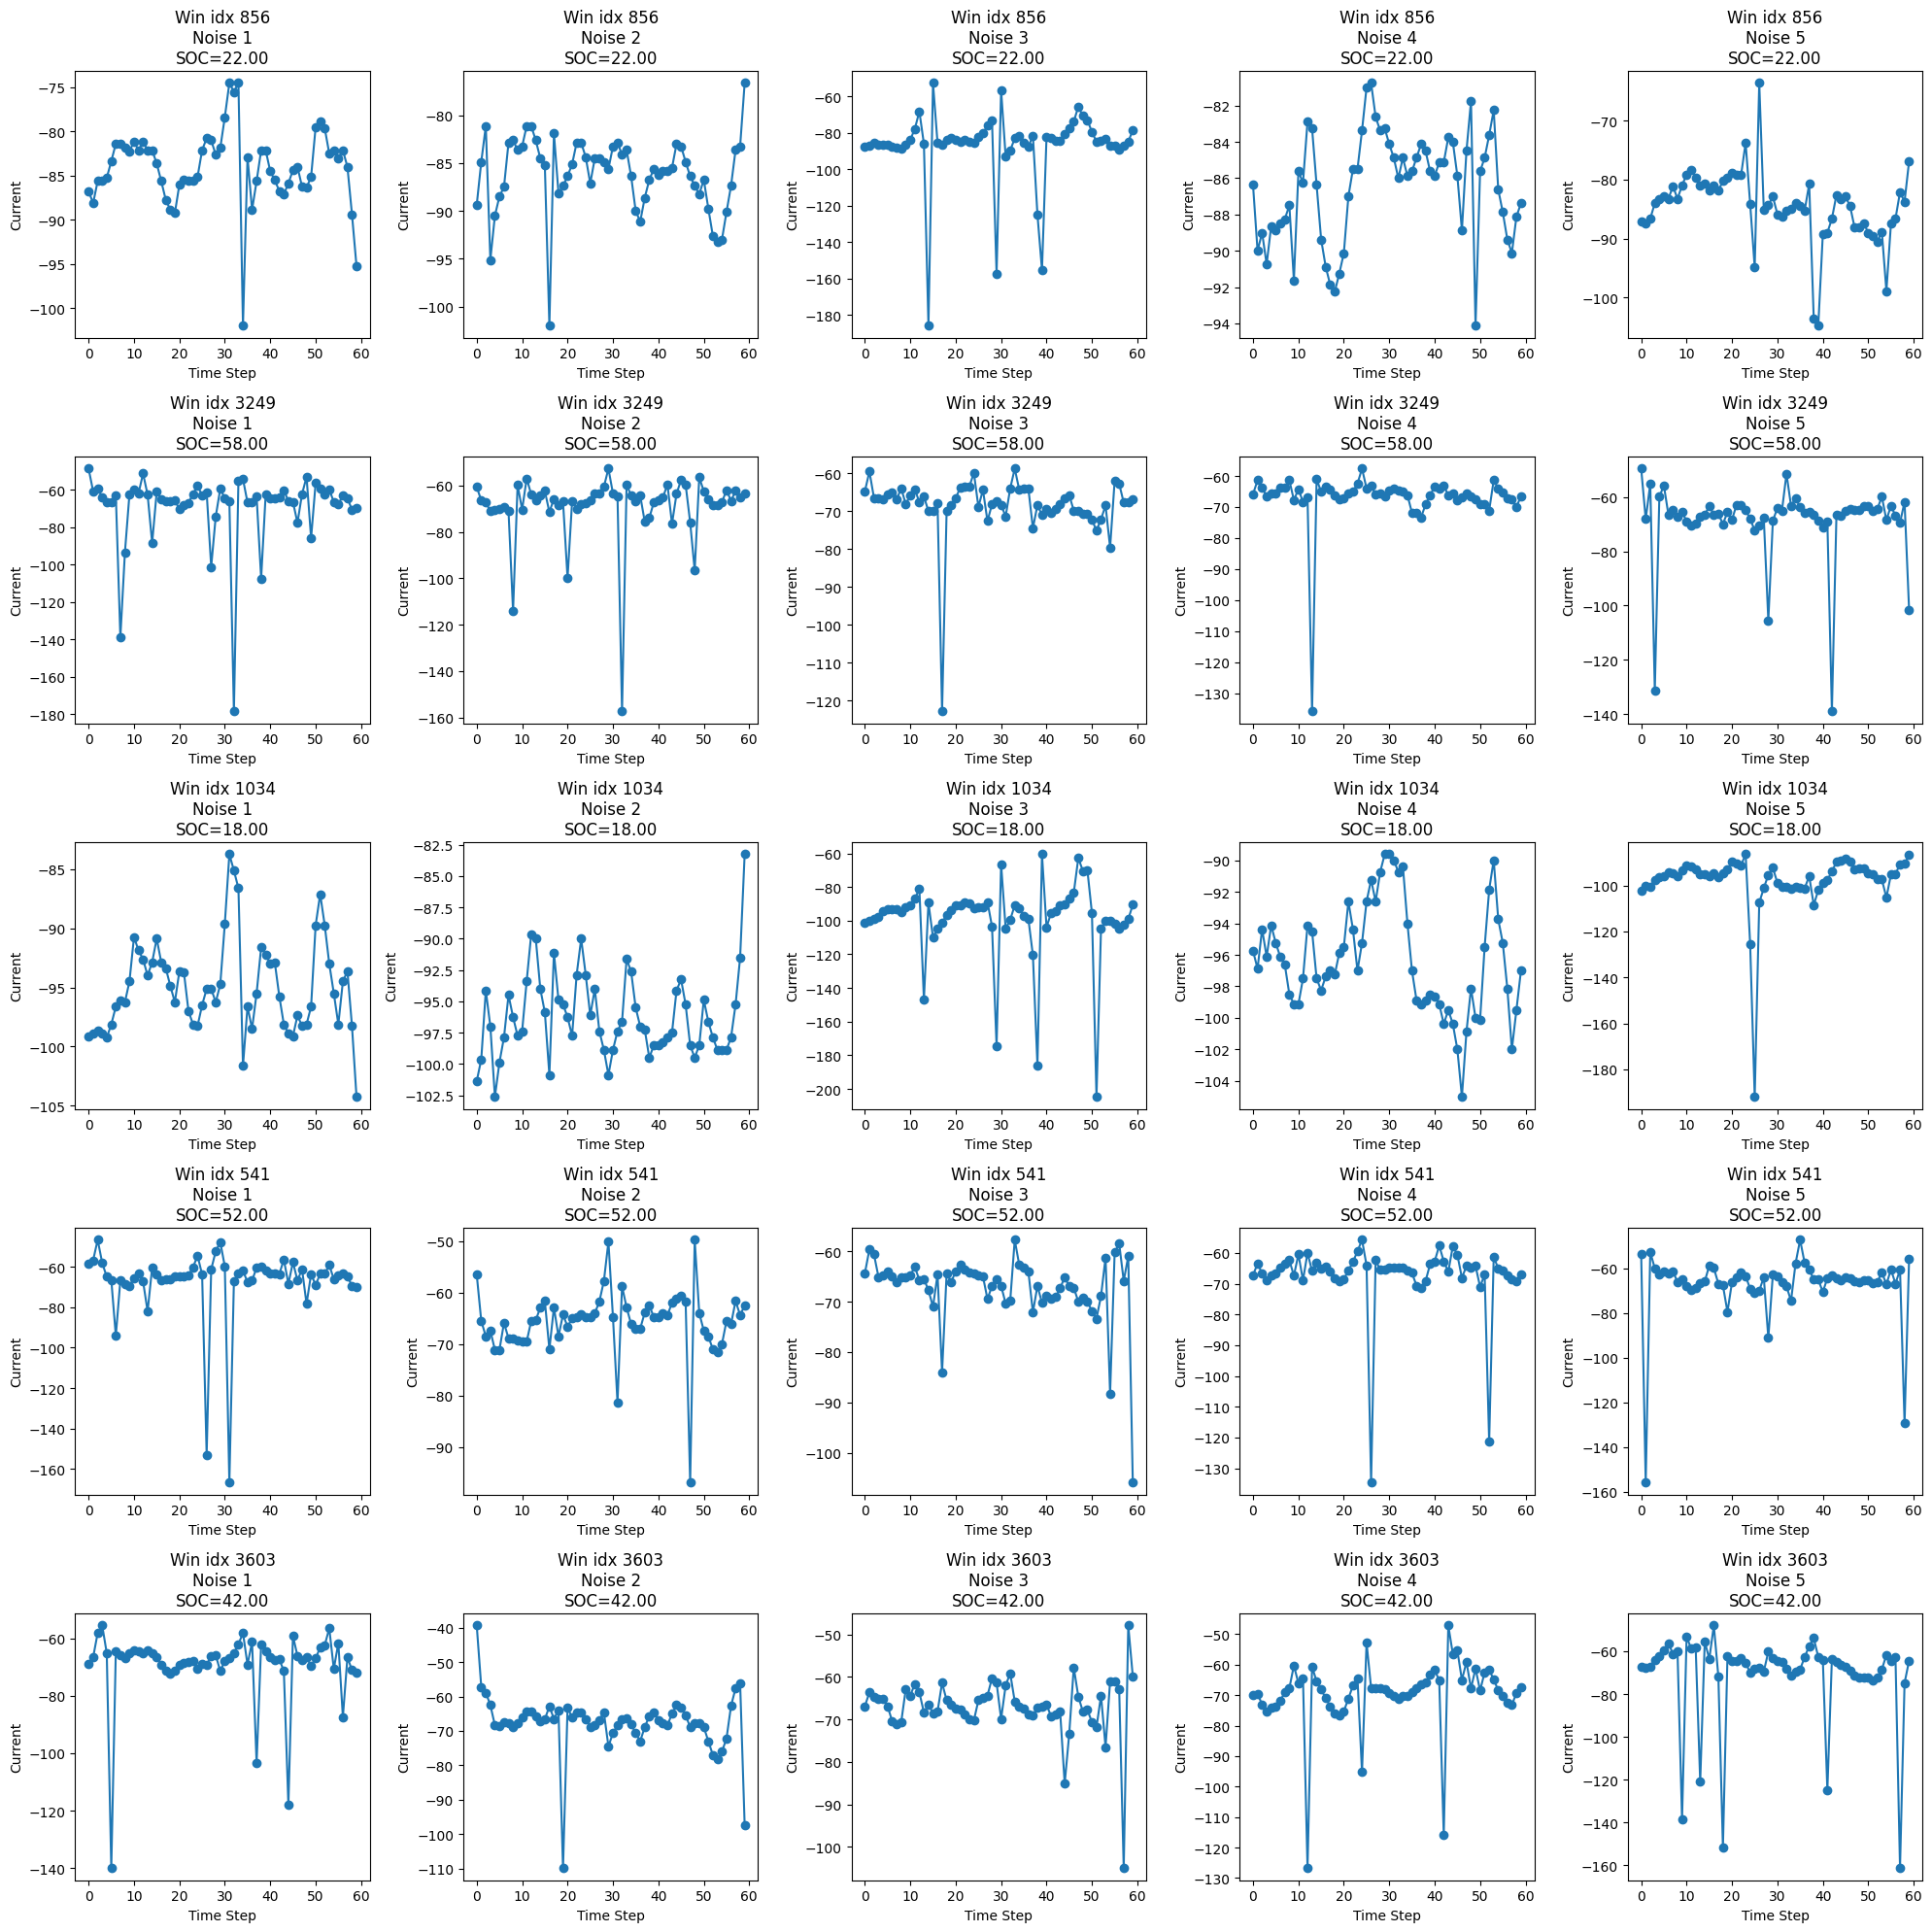

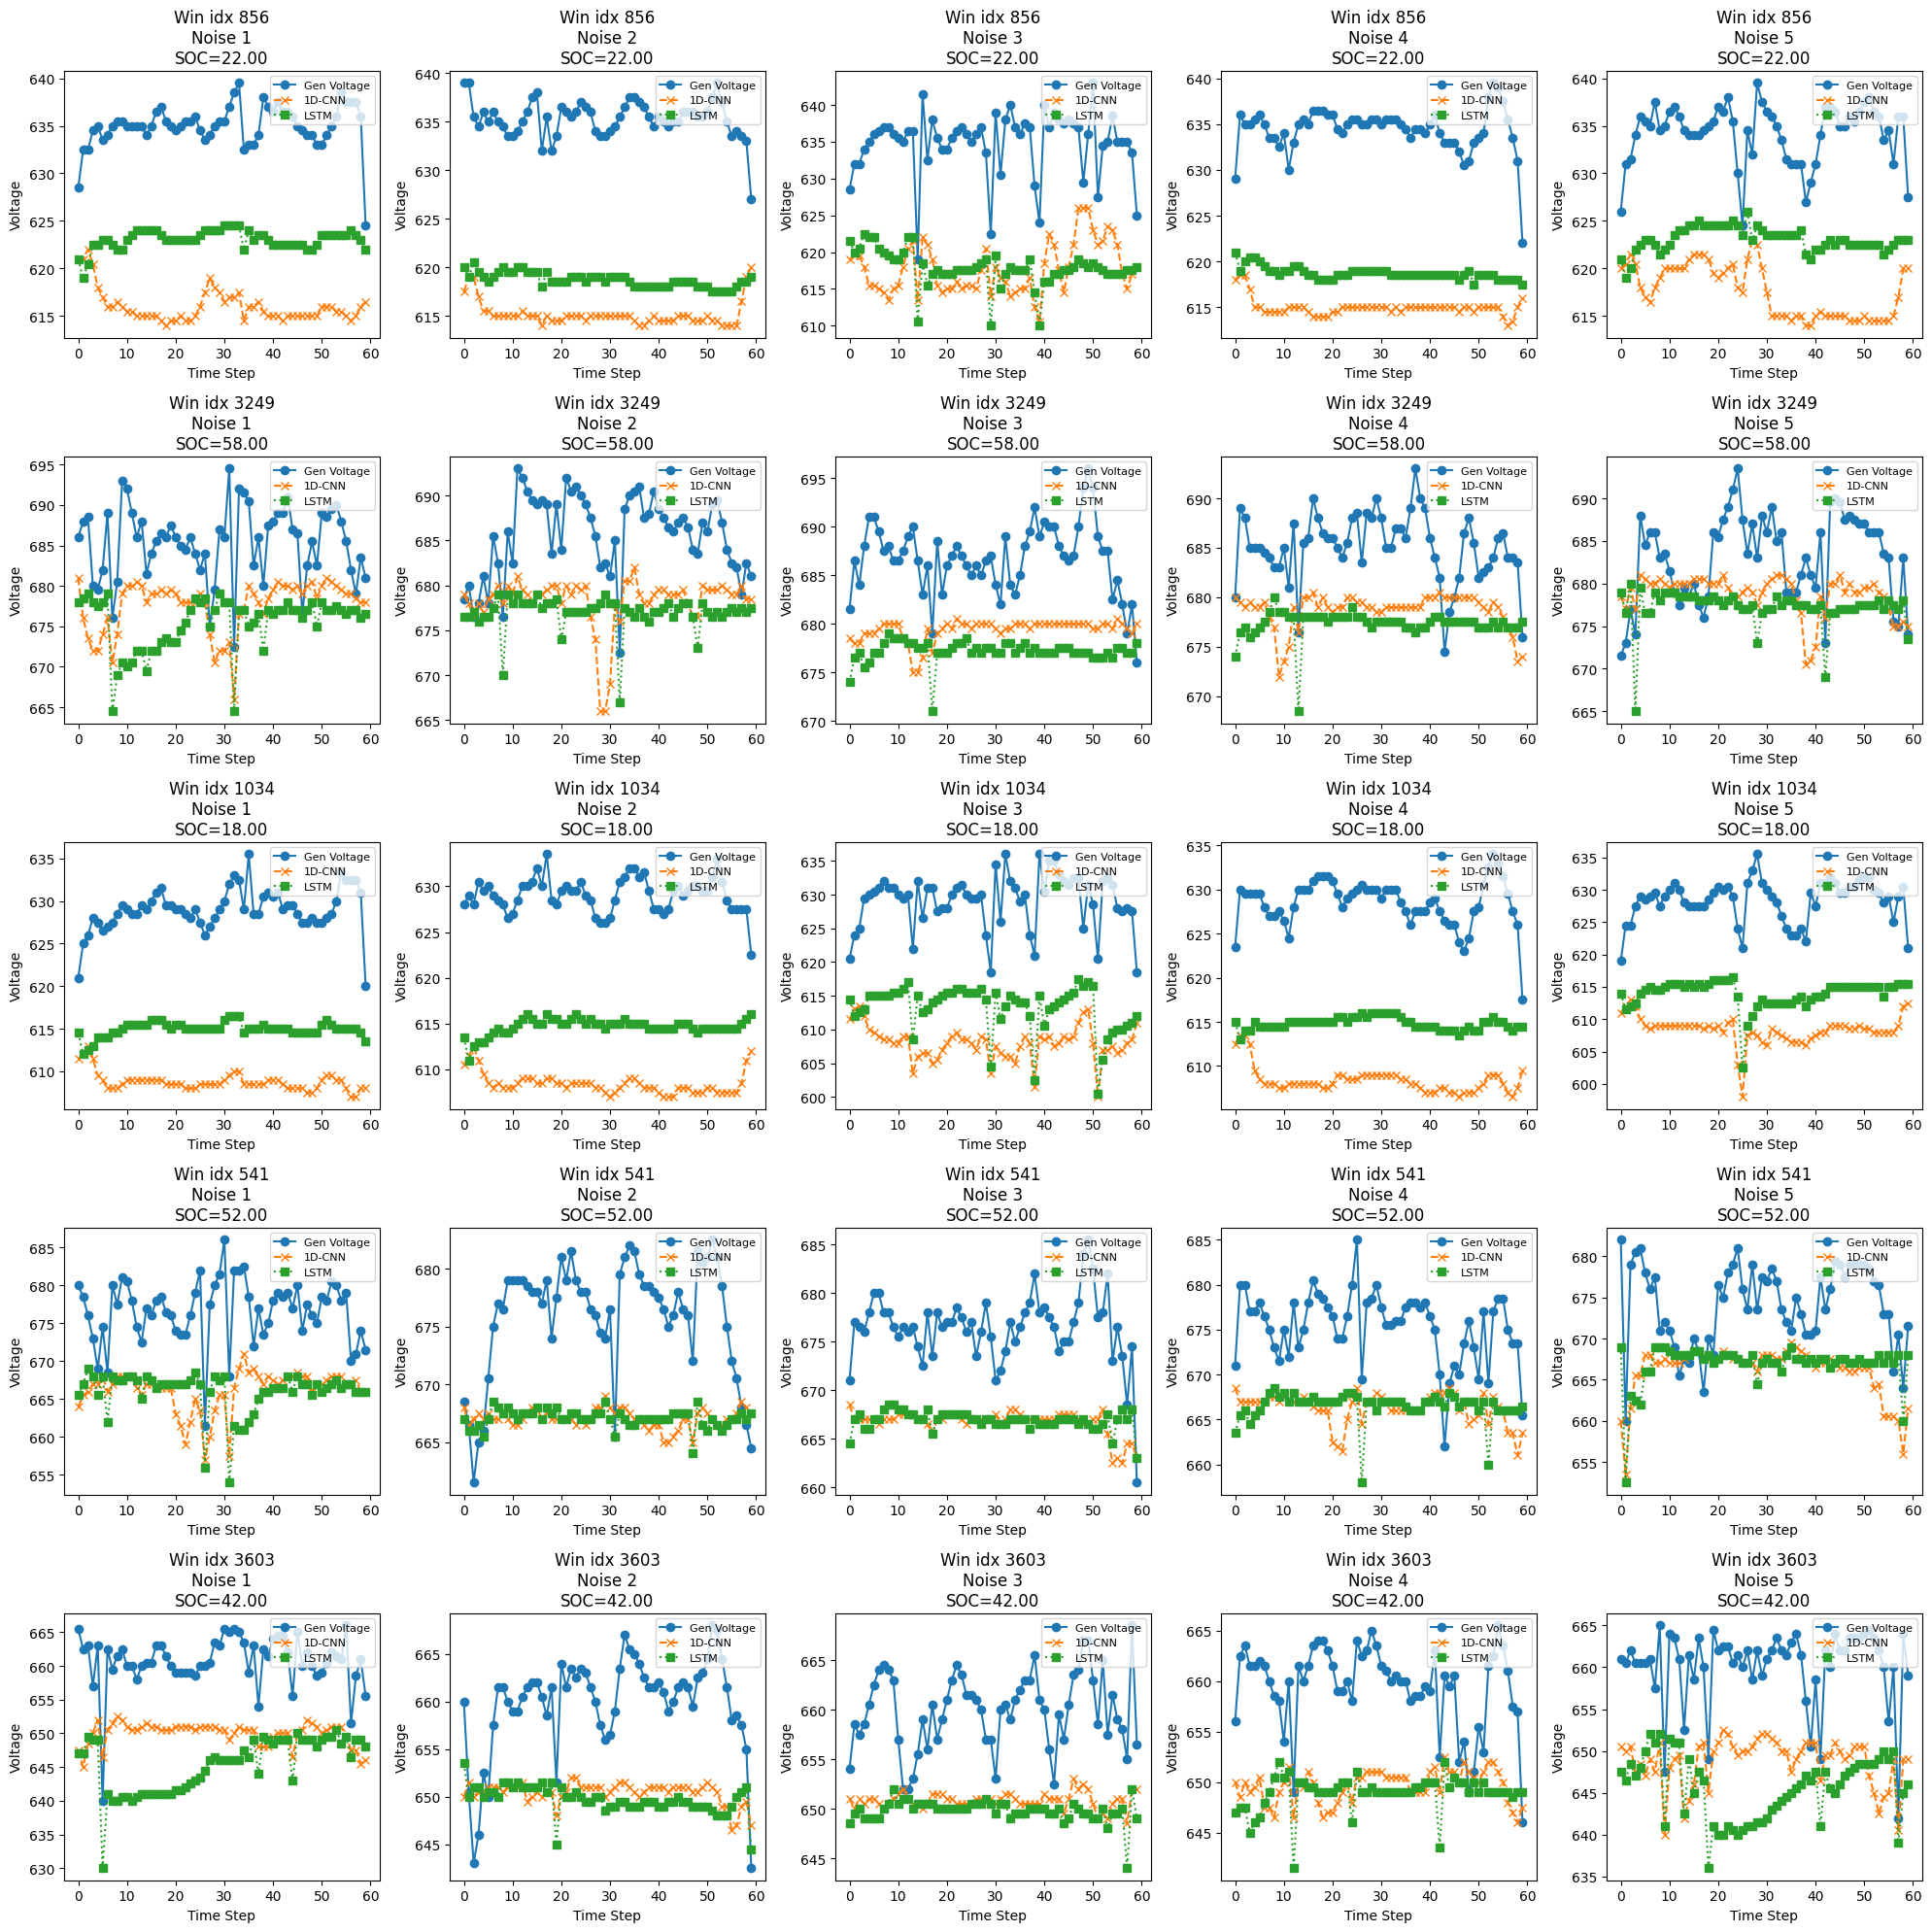

Window idx 856: Average correlation among generated current values = 0.053
Window idx 3249: Average correlation among generated current values = 0.014
Window idx 1034: Average correlation among generated current values = -0.039
Window idx 541: Average correlation among generated current values = 0.055
Window idx 3603: Average correlation among generated current values = 0.003


In [ ]:

import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# --- 전역 설정 ---
# all_sequences: (N, window_size, 4) → [전류, SOC, 전압, ΔI]
# window_size, latent_dim, data_min, data_max, generator_cond, get_condition, denormalize_feature 등이 이미 정의되어 있다고 가정

# 예시: 단일 Generator 모델 경로 (250317 모델)
# generator_path는 전역 변수로 정의되어 있다고 가정합니다.
# Teacher 모델 로드 (1-D CNN과 LSTM)
teacher_model = teacher_1d      # 1-D CNN Teacher
teacher_model_2 = teacher_lstm  # LSTM Teacher
teacher_model.trainable = False
teacher_model_2.trainable = False


# 원하는 윈도우 인덱스 랜덤 선택 (매 실행마다 변경)
random_indices = np.random.choice(len(all_sequences), size=5, replace=False)
print("Selected window indices:", random_indices)

# 각 선택된 윈도우에서 SOC 추출 및 평균 계산
cond_list = []
soc_last_list = []  # 각 윈도우의 마지막 SOC (denormalized)
for idx in random_indices:
    real_window = all_sequences[idx]  # shape: (window_size, 4)
    # SOC 채널(인덱스 1) 추출 → shape: (window_size, 1)
    soc = real_window[:, 1:2]
    soc = soc[np.newaxis, ...]         # (1, window_size, 1)
    cond_list.append(soc)
    # 윈도우의 마지막 SOC 값 사용 (학습 시 사용한 조건과 동일)
    last_soc = soc[0, -1, 0]  # 마지막 time step의 SOC (scalar)
    last_soc_denorm = last_soc * (data_max[1] - data_min[1] + 1e-7) + data_min[1]
    soc_last_list.append(last_soc_denorm)

# Noise 샘플 개수
num_noise_samples = 5

# 각 noise 샘플은 매번 랜덤하게 생성 (latent_dim, window_size 전역 변수 사용)
noise_list = [ tf.random.normal([1, window_size, latent_dim]) for _ in range(num_noise_samples) ]

# Generator 모델 로드
print(f"Loading generator model from: {generator_path}")
generator_model = load_model(generator_path)

# 결과 저장:
# 각 윈도우(cond_list) x 각 Noise 샘플(noise_list)에 대해:
#  - gen_current
#  - gen_voltage
#  - teacher_voltage1 (1-D CNN)
#  - teacher_voltage2 (LSTM)
results_current = []
results_voltage = []
results_teacher1 = []
results_teacher2 = []

for soc_cond in cond_list:
    current_list = []
    voltage_list = []
    teacher1_list = []
    teacher2_list = []

    for noise_sample in noise_list:
        latent_output = generator_model([noise_sample, soc_cond], training=False)  # (1, window_size, 3)
        generated_seq = combine_output(latent_output, soc_cond)                   # (1, window_size, 4)

        # 전류 (index=0)와 전압 (index=2) 추출
        gen_current = generated_seq[0, :, 0].numpy()
        gen_voltage = generated_seq[0, :, 2].numpy()

        # Teacher 모델 입력: [전류, SOC, ΔI] (인덱스 [0,1,3])
        teacher_input = tf.gather(generated_seq, indices=[0,1,3], axis=-1)  # (1, window_size, 3)
        t_v1 = teacher_model(teacher_input, training=False)[0, :, 0].numpy()
        t_v2 = teacher_model_2(teacher_input, training=False)[0, :, 0].numpy()

        current_list.append(gen_current)
        voltage_list.append(gen_voltage)
        teacher1_list.append(t_v1)
        teacher2_list.append(t_v2)

    results_current.append(current_list)
    results_voltage.append(voltage_list)
    results_teacher1.append(teacher1_list)
    results_teacher2.append(teacher2_list)

# Denormalization 함수 (전류: index=0, 전압: index=2)
def denorm(arr, feature_index):
    # arr: 1D array (window_size,)
    return arr * (data_max[feature_index] - data_min[feature_index] + 1e-7) + data_min[feature_index]

# 결과 denormalization
results_current_denorm = []
results_voltage_denorm = []
results_teacher1_denorm = []
results_teacher2_denorm = []

for w in range(len(cond_list)):
    curr_denorm_list = []
    volt_denorm_list = []
    teach1_denorm_list = []
    teach2_denorm_list = []

    for n in range(num_noise_samples):
        denorm_current = denorm(results_current[w][n], 0)
        denorm_voltage = denorm(results_voltage[w][n], 2)
        denorm_t1      = denorm(results_teacher1[w][n], 2)
        denorm_t2      = denorm(results_teacher2[w][n], 2)

        curr_denorm_list.append(denorm_current)
        volt_denorm_list.append(denorm_voltage)
        teach1_denorm_list.append(denorm_t1)
        teach2_denorm_list.append(denorm_t2)

    results_current_denorm.append(curr_denorm_list)
    results_voltage_denorm.append(volt_denorm_list)
    results_teacher1_denorm.append(teach1_denorm_list)
    results_teacher2_denorm.append(teach2_denorm_list)

# ------------------------------
# 플롯
# ------------------------------
num_windows = len(random_indices)

# (1) 전류 플롯: 각 윈도우 x 각 Noise
plt.figure(figsize=(num_noise_samples * 4, num_windows * 4))
for w in range(num_windows):
    for n in range(num_noise_samples):
        plt.subplot(num_windows, num_noise_samples, w*num_noise_samples + n + 1)
        plt.plot(results_current_denorm[w][n], marker='o', linestyle='-')
        plt.title(f"Win idx {random_indices[w]}\nNoise {n+1}\nSOC={soc_last_list[w]:.2f}")
        plt.xlabel("Time Step")
        plt.ylabel("Current")
plt.tight_layout()
plt.show()

# (2) 전압 플롯 (Teacher 모델 포함): 각 윈도우 x 각 Noise
plt.figure(figsize=(num_noise_samples * 4, num_windows * 4))
for w in range(num_windows):
    for n in range(num_noise_samples):
        plt.subplot(num_windows, num_noise_samples, w*num_noise_samples + n + 1)
        plt.plot(results_voltage_denorm[w][n], marker='o', linestyle='-', label="Gen Voltage")
        plt.plot(results_teacher1_denorm[w][n], marker='x', linestyle='--', label="1D-CNN")
        plt.plot(results_teacher2_denorm[w][n], marker='s', linestyle=':', label="LSTM")
        plt.title(f"Win idx {random_indices[w]}\nNoise {n+1}\nSOC={soc_last_list[w]:.2f}")
        plt.xlabel("Time Step")
        plt.ylabel("Voltage")
        plt.legend(loc='upper right', fontsize=8)
plt.tight_layout()
plt.show()

# 각 윈도우별 생성 전류 시계열들의 pairwise correlation 계산
for w in range(num_windows):
    correlations = []
    for i in range(num_noise_samples):
        for j in range(i+1, num_noise_samples):
            # results_current_denorm[w][i]와 results_current_denorm[w][j]는 각각 (window_size,) 형태의 1D 배열
            corr = np.corrcoef(results_current_denorm[w][i], results_current_denorm[w][j])[0, 1]
            correlations.append(corr)
    avg_corr = np.mean(correlations)
    print(f"Window idx {random_indices[w]}: Average correlation among generated current values = {avg_corr:.3f}")


Selected window indices: [1321 1878 3424 3949 3803]


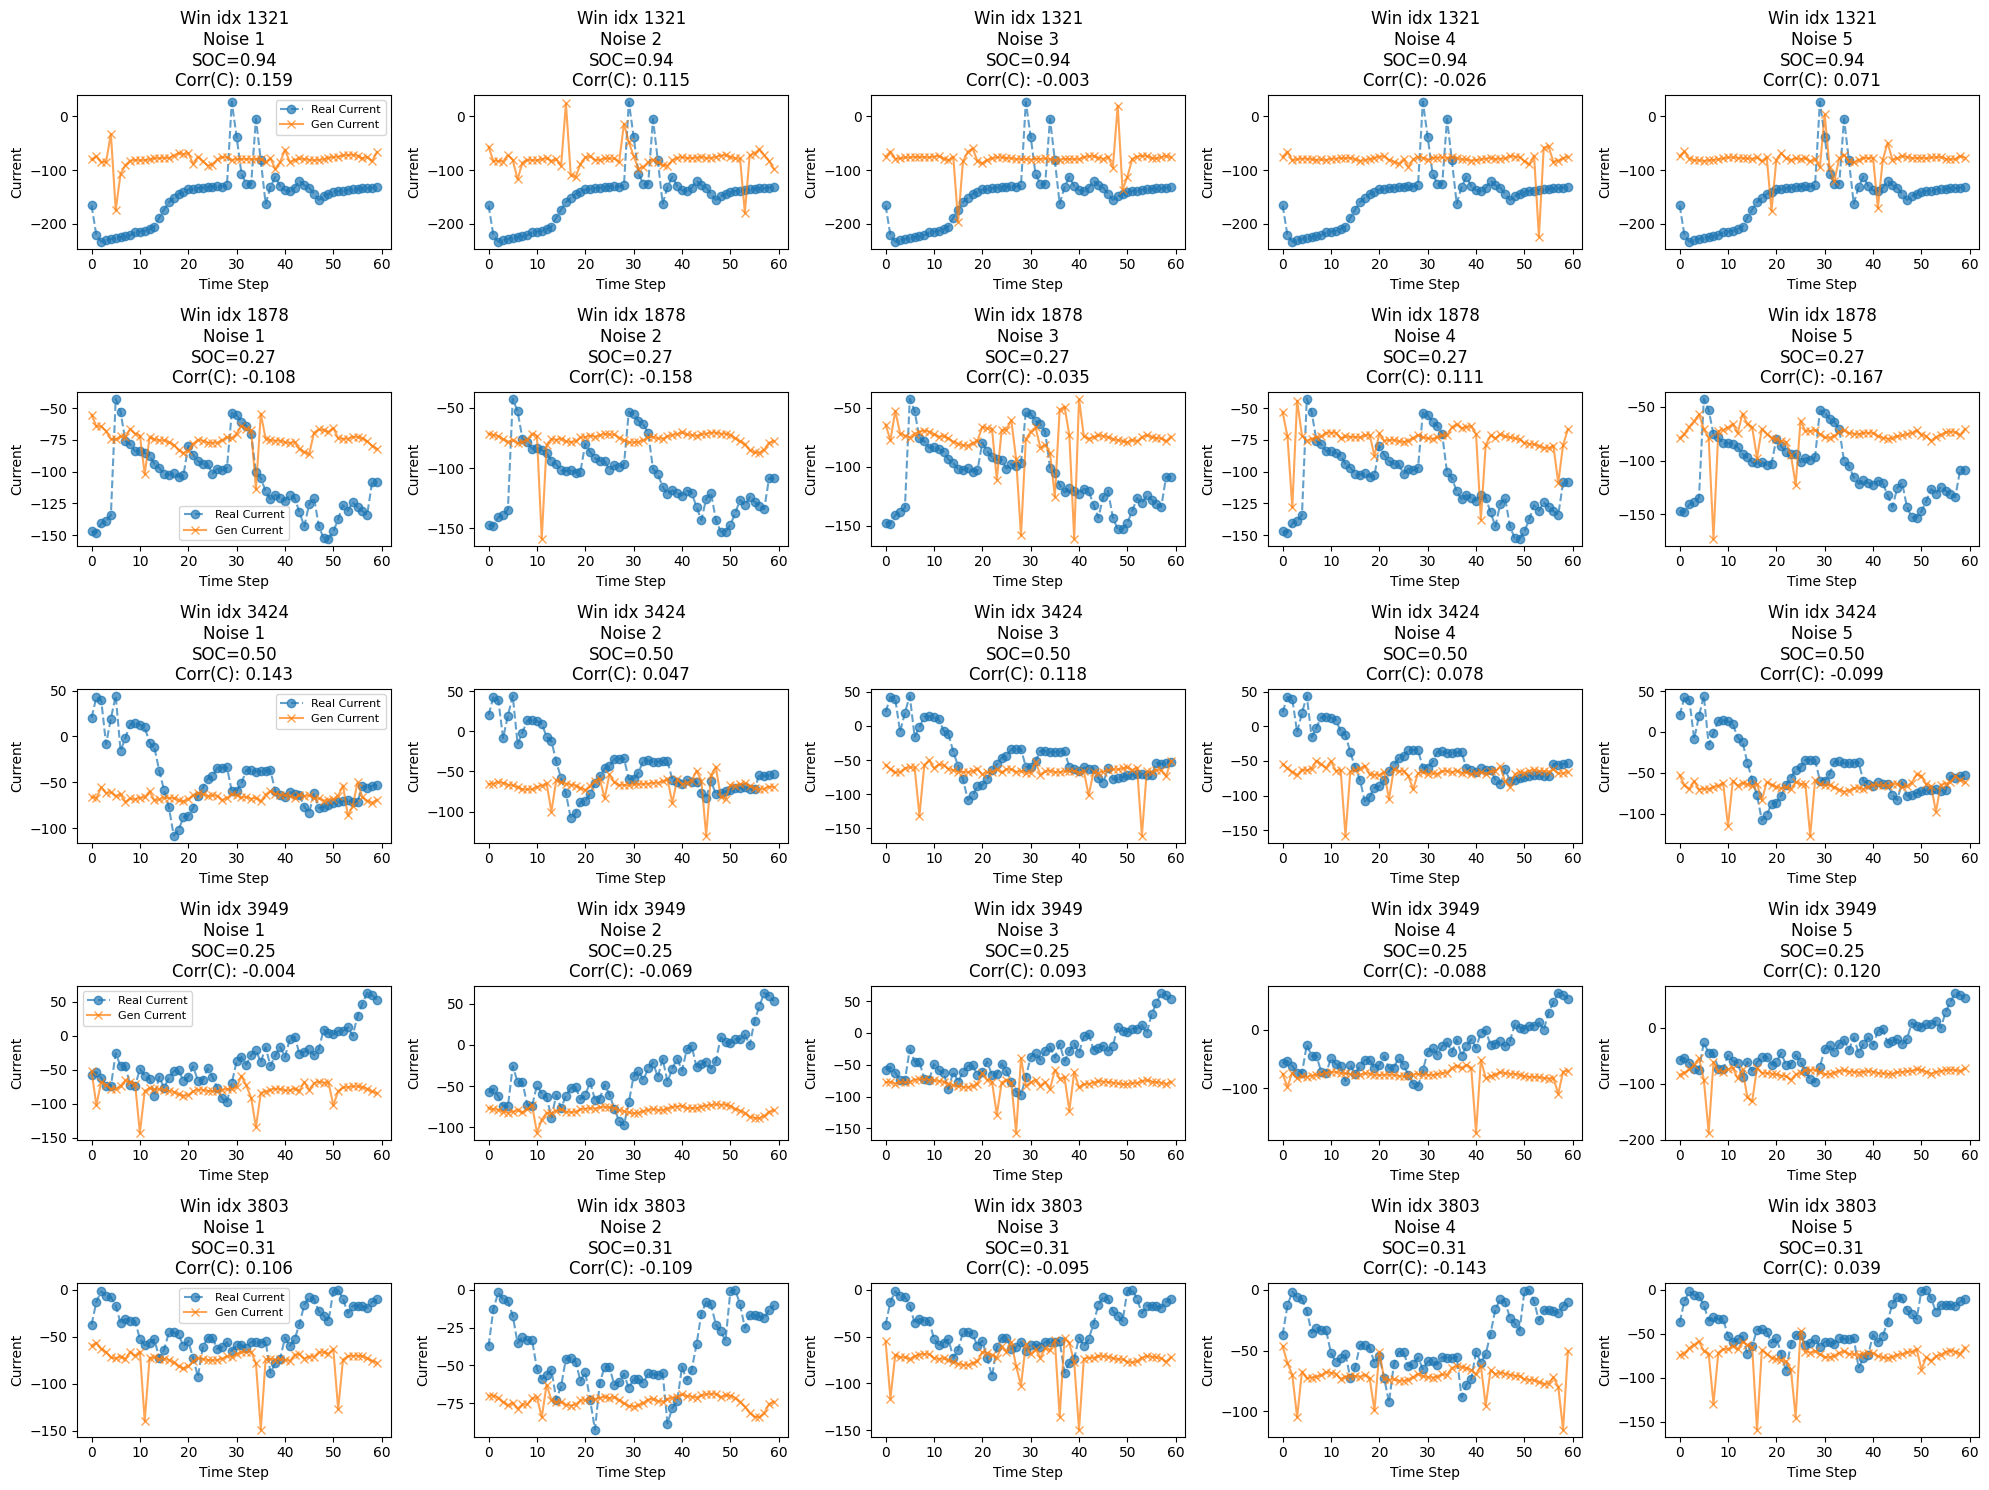

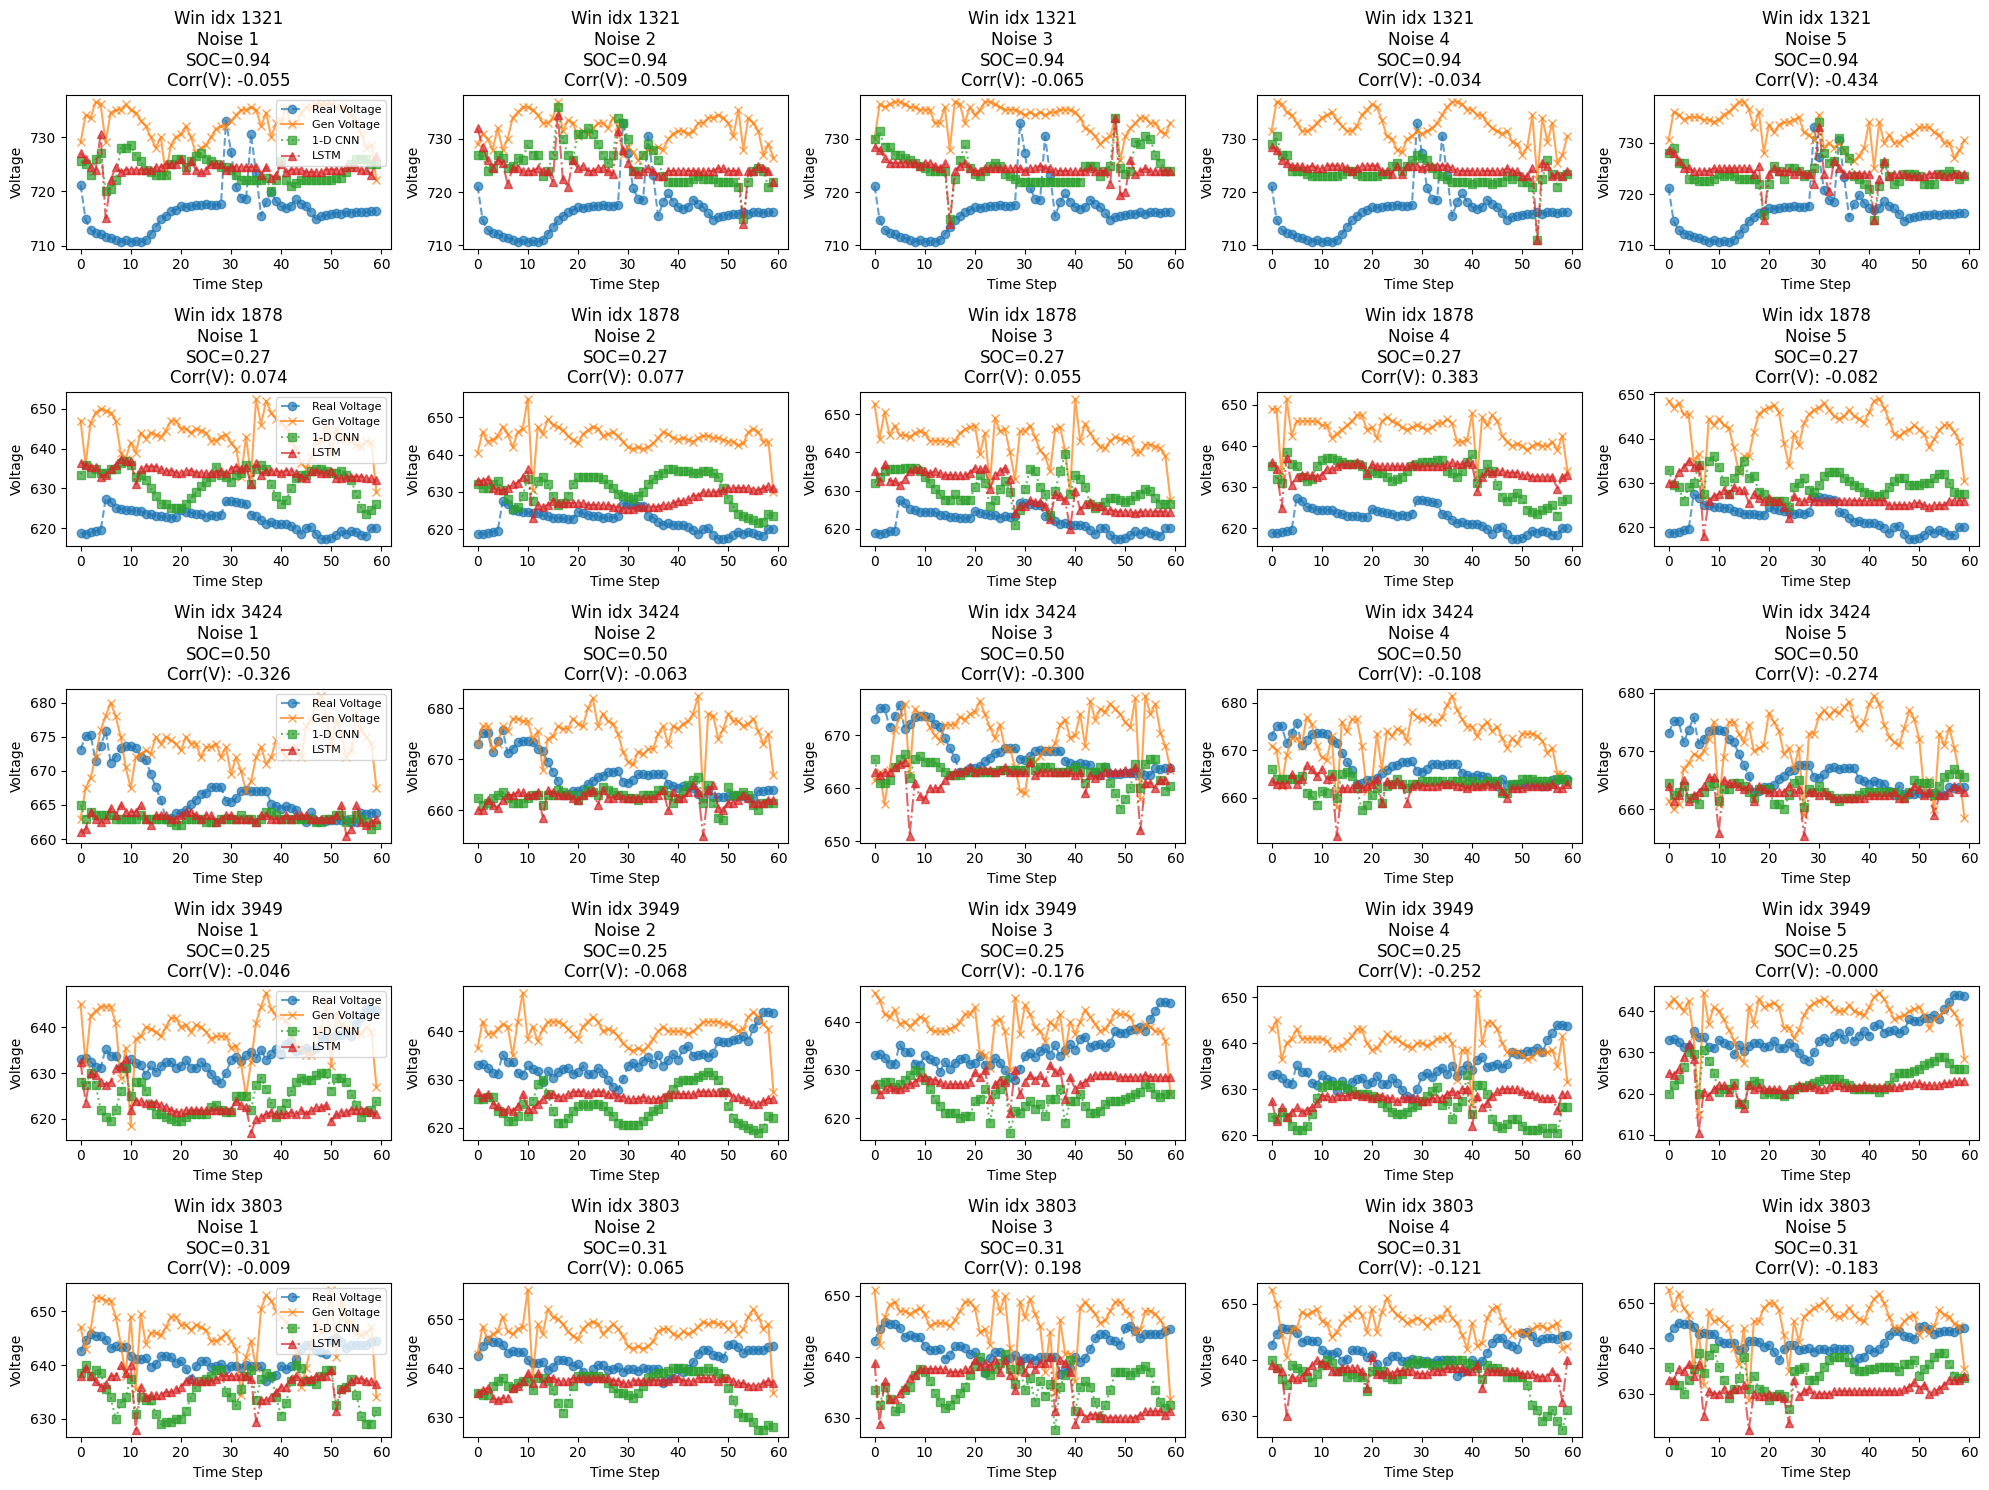

In [ ]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# --- 전역 설정 ---
# all_sequences: (N, window_size, 4) → [전류, SOC, 전압, ΔI]
# window_size, latent_dim, data_min, data_max, generator_cond, get_condition, denormalize_feature 등이 이미 정의되어 있다고 가정
# data_min, data_max 배열은 채널 순서 [전류, SOC, 전압, ΔI]에 맞게 정의됨

# 예시: 단일 Generator 모델 경로 (250317 모델)
# generator_path는 전역 변수로 정의되어 있다고 가정합니다.

# 랜덤하게 5개의 윈도우 인덱스 선택
random_indices = np.random.choice(len(all_sequences), size=5, replace=False)
print("Selected window indices:", random_indices)

# 각 윈도우마다 별도의 noise 샘플 생성 (총 5개)
num_noise_samples = 5
noise_list = [ tf.random.normal([1, window_size, latent_dim]) for _ in range(num_noise_samples) ]

# Denormalization 함수 (원본 데이터 ordering: [전류, SOC, 전압, ΔI])
def denorm(arr, feature_index):
    # arr: 1D array (window_size,)
    return arr * (data_max[feature_index] - data_min[feature_index] + 1e-7) + data_min[feature_index]

# --- 평가를 위한 결과 저장 ---
# 각 선택된 윈도우에 대해, 각 noise 샘플마다 생성된 결과를 저장합니다.
# 각 결과는 튜플:
# (gen_current, gen_voltage, teacher_voltage1, teacher_voltage2, corr_current, corr_voltage, avg_SOC)
results = []
real_results = []  # 실제 window의 전류, 전압 (denormalized) 저장

for idx in random_indices:
    # 고정 윈도우 추출 (shape: (window_size, 4)) - [전류, SOC, 전압, ΔI]
    real_window = all_sequences[idx]
    real_current_norm = real_window[:, 0]  # index 0: 전류
    real_voltage_norm = real_window[:, 2]  # index 2: 전압
    real_current = denorm(real_current_norm, 0)
    real_voltage = denorm(real_voltage_norm, 2)
    real_results.append((real_current, real_voltage))

    window_results = []
    # 해당 윈도우의 SOC 추출 (shape: (1, window_size, 1))
    soc = real_window[:, 1:2][np.newaxis, ...]
    # 윈도우의 마지막 SOC 값 (denormalized) 사용
    last_soc = soc[0, -1, 0]  # scalar (정규화된 값)
    last_soc_denorm = last_soc * (data_max[1] - data_min[1] + 1e-7) + data_min[1]

    for noise_sample in noise_list:
        # Generator 실행: 입력은 (noise_sample, soc)
        latent_output = generator_model([noise_sample, soc], training=False)  # shape: (1, window_size, 3)
        generated_seq = combine_output(latent_output, soc)                   # shape: (1, window_size, 4)

        # 전류와 전압 추출 (전류: index 0, 전압: index 2)
        gen_current_norm = generated_seq[0, :, 0].numpy()
        gen_voltage_norm = generated_seq[0, :, 2].numpy()
        gen_current = denorm(gen_current_norm, 0)
        gen_voltage = denorm(gen_voltage_norm, 2)

        # Teacher 모델 입력: 생성된 시퀀스에서 [전류, SOC, ΔI] (인덱스 [0,1,3])
        teacher_input = tf.gather(generated_seq, indices=[0,1,3], axis=-1)  # shape: (1, window_size, 3)
        teacher_voltage1_norm = teacher_model(teacher_input, training=False)[0, :, 0].numpy()
        teacher_voltage2_norm = teacher_model_2(teacher_input, training=False)[0, :, 0].numpy()
        teacher_voltage1 = denorm(teacher_voltage1_norm, 2)
        teacher_voltage2 = denorm(teacher_voltage2_norm, 2)

        # Correlation 계산 (실제와 생성된 값 사이)
        corr_current = np.corrcoef(real_current, gen_current)[0, 1]
        corr_voltage = np.corrcoef(real_voltage, gen_voltage)[0, 1]

        window_results.append((gen_current, gen_voltage, teacher_voltage1, teacher_voltage2,
                               corr_current, corr_voltage, last_soc))
    results.append(window_results)

# --- Plotting ---
# 플롯: 각 윈도우마다 noise 샘플별 subplot을 구성합니다.
num_windows = len(random_indices)
num_noises = num_noise_samples

# (1) 전류 플롯
plt.figure(figsize=(num_noises * 4, num_windows * 3))
for w in range(num_windows):
    for n in range(num_noises):
        plt.subplot(num_windows, num_noises, w*num_noises + n + 1)
        gen_current = results[w][n][0]
        plt.plot(real_results[w][0], marker='o', linestyle='--', alpha=0.7, label='Real Current')
        plt.plot(gen_current, marker='x', linestyle='-', alpha=0.7, label='Gen Current')
        plt.title(f"Win idx {random_indices[w]}\nNoise {n+1}\nSOC={results[w][n][6]:.2f}\nCorr(C): {results[w][n][4]:.3f}")
        plt.xlabel("Time Step")
        plt.ylabel("Current")
        if n == 0:
            plt.legend(fontsize=8)
plt.tight_layout()
plt.show()

# (2) 전압 플롯 (Teacher 모델 포함)
plt.figure(figsize=(num_noises * 4, num_windows * 3))
for w in range(num_windows):
    for n in range(num_noises):
        plt.subplot(num_windows, num_noises, w*num_noises + n + 1)
        gen_voltage = results[w][n][1]
        teacher_voltage1 = results[w][n][2]
        teacher_voltage2 = results[w][n][3]
        plt.plot(real_results[w][1], marker='o', linestyle='--', alpha=0.7, label='Real Voltage')
        plt.plot(gen_voltage, marker='x', linestyle='-', alpha=0.7, label='Gen Voltage')
        plt.plot(teacher_voltage1, marker='s', linestyle=':', alpha=0.7, label='1-D CNN')
        plt.plot(teacher_voltage2, marker='^', linestyle='-.', alpha=0.7, label='LSTM')
        plt.title(f"Win idx {random_indices[w]}\nNoise {n+1}\nSOC={results[w][n][6]:.2f}\nCorr(V): {results[w][n][5]:.3f}")
        plt.xlabel("Time Step")
        plt.ylabel("Voltage")
        if n == 0:
            plt.legend(loc='upper right', fontsize=8)
plt.tight_layout()
plt.show()


Loading generator model from: C:\Users\user\Desktop\JANG\code\AI\250322\JSAE_generator_epoch_250322_600.h5
Selected window indices: [2530 3052 3948  479 2256]


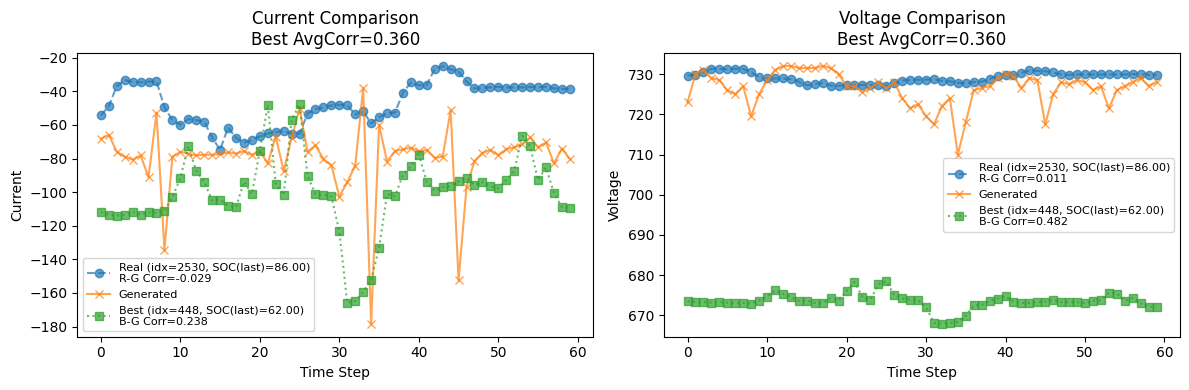

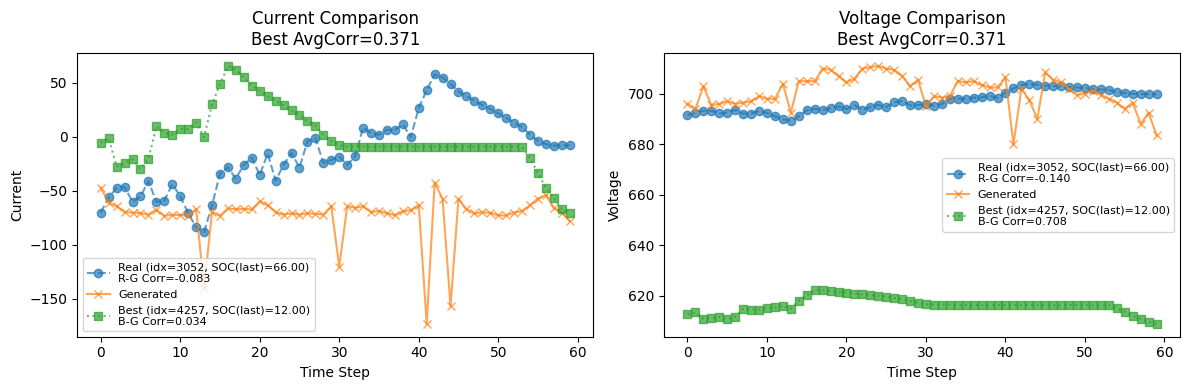

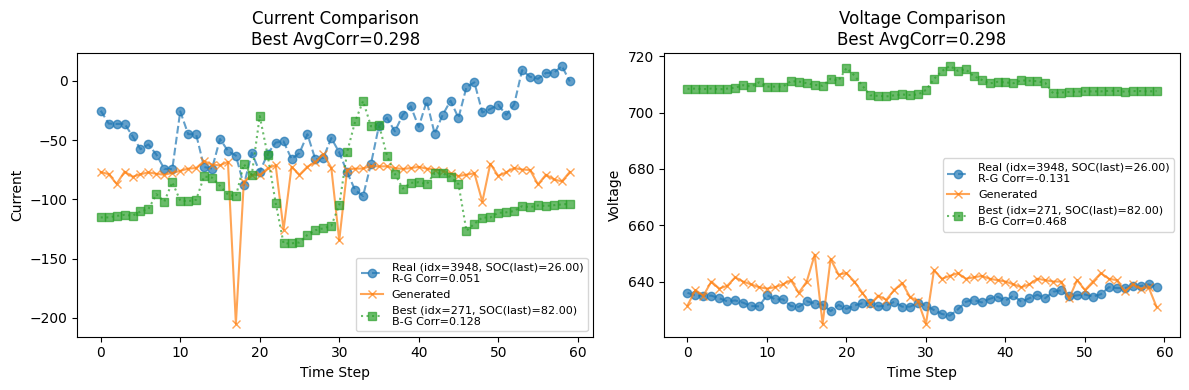

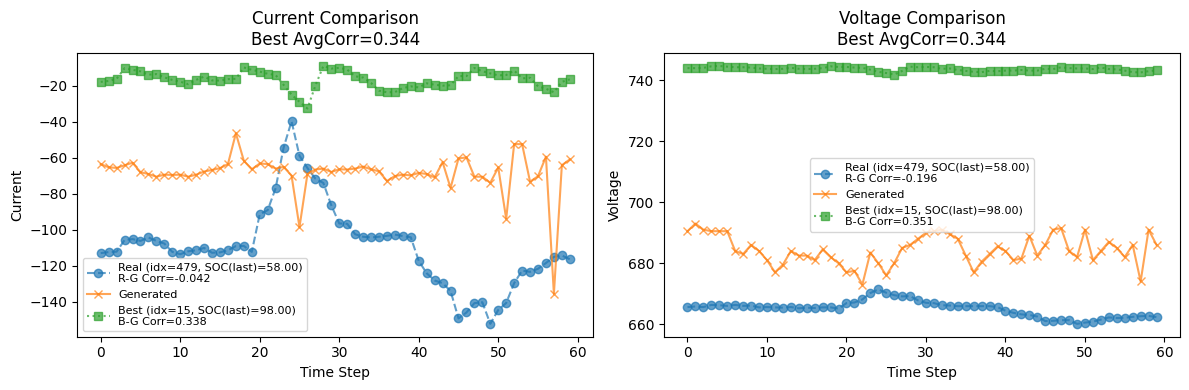

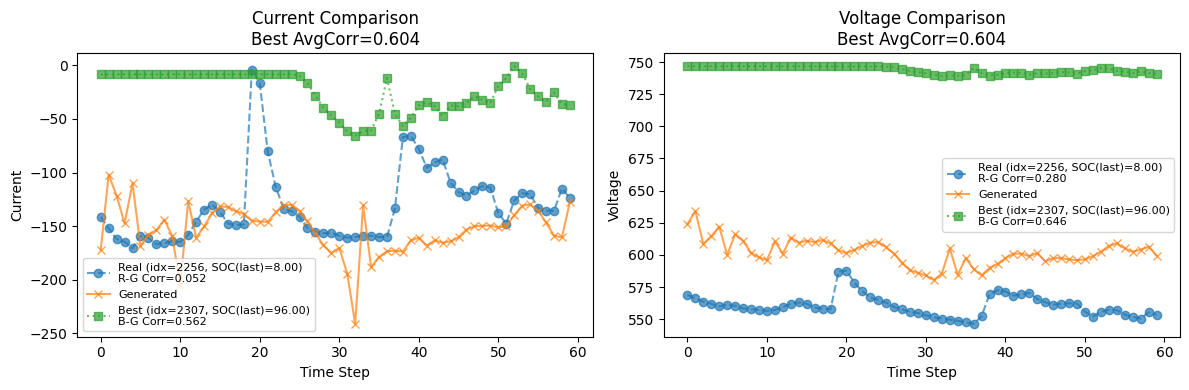

In [ ]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# --- 전역 설정 ---
# all_sequences: (N, window_size, 4) → [전류, SOC, 전압, ΔI]
# window_size, latent_dim, data_min, data_max 등이 이미 정의되어 있다고 가정

# 1) Generator 모델 로드
print(f"Loading generator model from: {generator_path}")
generator_model = load_model(generator_path)

# 3) 5개의 랜덤 윈도우 인덱스 선택
num_windows_total = len(all_sequences)
random_indices = np.random.choice(num_windows_total, size=5, replace=False)
print("Selected window indices:", random_indices)

# Denormalization 함수 (원본 데이터 ordering: [전류, SOC, 전압, ΔI])
def denorm(arr, feature_index):
    return arr * (data_max[feature_index] - data_min[feature_index] + 1e-7) + data_min[feature_index]

# --- 평가를 위한 결과 저장 ---
# 각 선택된 윈도우에 대해, 각 noise 샘플마다 생성된 결과를 저장합니다.
# 결과 튜플: (gen_current, gen_voltage, corr_current, corr_voltage, best_corr, fixed_idx, best_idx, fixed_SOC, best_SOC)
results = []
real_results = []  # 실제 window의 전류, 전압 (denormalized) 저장

for fixed_idx in random_indices:
    # (A) 해당 윈도우에서 real data 추출 (전류, 전압 복원)
    real_window = all_sequences[fixed_idx]  # shape: (window_size, 4)
    real_current_norm = real_window[:, 0]     # 정규화된 전류
    real_voltage_norm = real_window[:, 2]     # 정규화된 전압
    real_current = denorm(real_current_norm, 0)
    real_voltage = denorm(real_voltage_norm, 2)
    real_results.append((real_current, real_voltage))

    # (B) 해당 윈도우에서 SOC 조건 추출
    soc = real_window[:, 1:2][np.newaxis, ...]  # (1, window_size, 1)
    # 윈도우의 마지막 SOC 값 (정규화된 값) 사용
    fixed_soc = soc[0, -1, 0]
    fixed_soc_denorm = fixed_soc * (data_max[1] - data_min[1] + 1e-7) + data_min[1]

    # (C) Generator 실행 (noise는 매 윈도우마다 생성)
    noise = tf.random.normal([1, window_size, latent_dim])
    latent_out = generator_model([noise, soc], training=False)  # shape: (1, window_size, 3)
    generated_seq = combine_output(latent_out, soc)[0].numpy()   # shape: (window_size, 4)
    gen_current_norm = generated_seq[:, 0]
    gen_voltage_norm = generated_seq[:, 2]
    gen_current = denorm(gen_current_norm, 0)
    gen_voltage = denorm(gen_voltage_norm, 2)

    # (D) 전체 real 윈도우 중, 생성된 전류/전압과 가장 유사한 윈도우 찾기
    best_corr = -999
    best_idx = None
    best_current = None
    best_voltage = None
    for i in range(num_windows_total):
        rw = all_sequences[i]  # shape: (window_size, 4)
        rw_current = denorm(rw[:, 0], 0)
        rw_voltage = denorm(rw[:, 2], 2)
        corr_c = np.corrcoef(rw_current, gen_current)[0, 1]
        corr_v = np.corrcoef(rw_voltage, gen_voltage)[0, 1]
        avg_corr = 0.5 * (corr_c + corr_v)
        if avg_corr > best_corr:
            best_corr = avg_corr
            best_idx = i
            best_current = rw_current
            best_voltage = rw_voltage

    # Best 윈도우의 마지막 SOC 값 사용
    best_soc = all_sequences[best_idx][:, 1]
    best_soc_last = best_soc[-1]  # 정규화된 값
    best_soc_denorm = best_soc_last * (data_max[1] - data_min[1] + 1e-7) + data_min[1]

    # (E) 전류, 전압 상관계수 계산 (Real vs Generated, Best vs Generated)
    corr_c_rg = np.corrcoef(real_current, gen_current)[0, 1]  # Real vs Gen (전류)
    corr_c_bg = np.corrcoef(best_current, gen_current)[0, 1]  # Best vs Gen (전류)
    corr_v_rg = np.corrcoef(real_voltage, gen_voltage)[0, 1]  # Real vs Gen (전압)
    corr_v_bg = np.corrcoef(best_voltage, gen_voltage)[0, 1]  # Best vs Gen (전압)

    # 결과 저장 (여기서는 Real vs Gen 상관계수를 저장)
    results.append((gen_current, gen_voltage, corr_c_rg, corr_v_rg, best_corr,
                    fixed_idx, best_idx, fixed_soc_denorm, best_soc_denorm))

    # (F) 플롯: 1행 2열 subplot (왼쪽: 전류, 오른쪽: 전압)
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))

    axs[0].plot(real_current, marker='o', linestyle='--', alpha=0.7,
                label=f"Real (idx={fixed_idx}, SOC(last)={fixed_soc_denorm:.2f})\nR-G Corr={corr_c_rg:.3f}")
    axs[0].plot(gen_current, marker='x', linestyle='-', alpha=0.7, label="Generated")
    axs[0].plot(best_current, marker='s', linestyle=':', alpha=0.7,
                label=f"Best (idx={best_idx}, SOC(last)={best_soc_denorm:.2f})\nB-G Corr={corr_c_bg:.3f}")
    axs[0].set_title(f"Current Comparison\nBest AvgCorr={best_corr:.3f}")
    axs[0].set_xlabel("Time Step")
    axs[0].set_ylabel("Current")
    axs[0].legend(fontsize=8)

    axs[1].plot(real_voltage, marker='o', linestyle='--', alpha=0.7,
                label=f"Real (idx={fixed_idx}, SOC(last)={fixed_soc_denorm:.2f})\nR-G Corr={corr_v_rg:.3f}")
    axs[1].plot(gen_voltage, marker='x', linestyle='-', alpha=0.7, label="Generated")
    axs[1].plot(best_voltage, marker='s', linestyle=':', alpha=0.7,
                label=f"Best (idx={best_idx}, SOC(last)={best_soc_denorm:.2f})\nB-G Corr={corr_v_bg:.3f}")
    axs[1].set_title(f"Voltage Comparison\nBest AvgCorr={best_corr:.3f}")
    axs[1].set_xlabel("Time Step")
    axs[1].set_ylabel("Voltage")
    axs[1].legend(fontsize=8)

    plt.tight_layout()
    plt.show()
